IN THIS NOTEBOOK, CORRELATION ANALYSIS BETWEEN EACH OF THE EXTRACTED SPEECH FEATURES(MFCC, X-VECTOR AND EMBEDDING), AND COSINE SIMILARITIES ARE CONDUCTED

STEP 1: load and preprocess the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

loaded_segment_df = pd.read_hdf('/content/drive/MyDrive/Speaker_diarization_project_data/features_selected_segments.h5', key='df')

In [ ]:
#organise the data based on speakers

loaded_segment_df['unique_speaker'] = loaded_segment_df['file'] + "_" + loaded_segment_df['Speaker']

grouped = loaded_segment_df.groupby(['file', 'unique_speaker'])

data_per_speaker = []
for (file_name, unique_speaker), group in grouped:
    mfcc_list = group['mfcc'].tolist()
    embedding_list = group['embedding'].tolist()
    xvector_list = group['xvector'].tolist()

    data_per_speaker.append({
        'file': file_name,
        'unique_speaker': unique_speaker,
        'mfccs': mfcc_list,
        'xvectors': xvector_list,
        'embeddings': embedding_list
    })

grouped_df = pd.DataFrame(data_per_speaker)

In [ ]:
#store the orgnised data
store_path = '/content/drive/MyDrive/Speaker_diarization_project_data/features_unique_speakers.pkl'
grouped_df.to_pickle(store_path)

STEP 2: prepare the parameters that will be used for correlation analysis, including:
- the cosine similarities obtained from different speech features (MFCC, x-vector or embedding) and averaged based on different granularities (segment level and speaker level)
- the MFCCs averaged based on different granularities
- the x-vectors averaged based on different granularities
- the embeddings averaged based on different granularities

STEP 2.1 : prepare the parameters that will be used in analysis 1, which is the analysis with cosine similarities of embeddings.

We analyse cosine similarities of embeddings in the first analysis as the referenced research (mentioned in README) us this parameter for analysis as well, so we assume this perspective of analysis are more standard.

STEP 2.1.1: preprocess the embeddings for analysis 1

In [ ]:
#calculate the speaker centroid based on embedding (the first part of correlation analyis are based on embedding based speaker centroid)
import numpy as np

for i, data in enumerate(data_per_speaker):
  #calculate the speaker centroid
  concatenated_embeddings = []
  #shape of data['embeddings']: (number of segments, number of frames, number of coefficients(512))
  for embedding_per_segment in data['embeddings']:
      #embedding shape in embedding_per_segment: (number of frame(1), number of coefficients(512))
      for embedding in embedding_per_segment:
          concatenated_embeddings.append(embedding)

  stacked_embeddings = np.vstack(concatenated_embeddings)
  speaker_centroid = np.mean(stacked_embeddings, axis=0)

  #shape of speaker_centroid: (512,)
  data['speaker_centroid'] = speaker_centroid

add_centroid_df = pd.DataFrame(data_per_speaker)

STEP 2.1.2: preprocess mfccs for analysis 1

In [ ]:
#calculate the segment based mean mfcc vectors

def calculate_mean_mfcc(speaker_mfccs):
    mean_mfcc_segments = []
    for mfcc_per_segment in speaker_mfccs:
        mean_mfcc = np.mean(mfcc_per_segment, axis=1)
        mean_mfcc_segments.append(mean_mfcc)
    return mean_mfcc_segments

add_centroid_df['mean_mfcc_segments'] = add_centroid_df['mfccs'].apply(calculate_mean_mfcc)

add_mean_mfcc_df = pd.DataFrame(add_centroid_df)

In [ ]:
#calculate the segment based mean mfcc values
def calculate_mean_mfcc_value(mean_mfccs_vectors):
    mean_mfcc_seg_value = []
    for mfcc_segments in mean_mfccs_vectors:
        mean_mfcc = np.mean(mfcc_segments, axis=0)
        mean_mfcc_seg_value.append(mean_mfcc)
    return mean_mfcc_seg_value

add_mean_mfcc_df['mean_mfcc_seg_value'] = add_mean_mfcc_df['mean_mfcc_segments'].apply(calculate_mean_mfcc_value)

add_mean_mfcc_value_df = pd.DataFrame(add_mean_mfcc_df)

In [ ]:
#calculate the speaker based mfcc vectors
def speaker_mean_mfcc_vector(mean_mfccs_vectors):
    speaker_mean_mfcc_vector = np.mean(mean_mfccs_vectors, axis=0)
    return speaker_mean_mfcc_vector

add_mean_mfcc_df['speaker_mfcc_vector'] = add_mean_mfcc_df['mean_mfcc_segments'].apply(speaker_mean_mfcc_vector)

add_mean_mfcc_df = pd.DataFrame(add_mean_mfcc_df)

In [ ]:
#calculate the speaker based mean mfcc values
def speaker_mean_mfcc_value(speaker_mean_mfcc_vector):
    speaker_mean_mfcc_value = np.mean(speaker_mean_mfcc_vector, axis=0)
    return speaker_mean_mfcc_value

add_mean_mfcc_df['speaker_mfcc_value'] = add_mean_mfcc_df['speaker_mfcc_vector'].apply(speaker_mean_mfcc_value)

add_mean_mfcc_df = pd.DataFrame(add_mean_mfcc_df)

STEP 2.1.3: preprocess xvectors for analysis 1

In [ ]:
#calculate the segment based mean xvector values
def calculate_mean_xvector_seg(xvectors):
    mean_xvector_seg_value = []
    for xvector_segments in xvectors:
        mean_xvector = np.mean(xvector_segments, axis=1)
        mean_xvector_seg_value.append(mean_xvector)
    return mean_xvector_seg_value

add_mean_mfcc_df['seg_mean_xvector_value'] = add_mean_mfcc_df['xvectors'].apply(calculate_mean_xvector_seg)

add_mean_xvector_df = pd.DataFrame(add_mean_mfcc_df)

In [ ]:
#calculate the speaker based mean xvector values
def speaker_mean_xvector_value(seg_mean_xvector_value):
    speaker_mean_xvector_value = np.mean(seg_mean_xvector_value, axis=0)
    return speaker_mean_xvector_value

add_mean_xvector_df['speaker_mean_xvector_value'] = add_mean_xvector_df['seg_mean_xvector_value'].apply(speaker_mean_xvector_value)

add_mean_xvector_df = pd.DataFrame(add_mean_xvector_df)

STEP 2.1.4: preprocess embeddings for analysis 1

In [ ]:
#calculate the segment based mean embedding values
def seg_mean_embedding_value(embeddings):
  mean_seg_list = []
  for embedding_per_seg in embeddings:
    mean_emb_seg = np.mean(embedding_per_seg,axis=0)
    mean_emb_seg = np.mean(embedding_per_seg)
    mean_seg_list.append(mean_emb_seg)
    """for embedding_per_frame in embedding_per_seg:
      mean_emb_frame = np.mean(embedding_per_frame,axis=)"""
  return mean_seg_list

add_mean_xvector_df['seg_embedding_value'] = add_mean_xvector_df['embeddings'].apply(seg_mean_embedding_value)

add_mean_xvector_df = pd.DataFrame(add_mean_xvector_df)

In [ ]:
#calculate the speaker based mean embedding values
def speaker_mean_embedding_value(embeddings):
    speaker_mean_embedding_value = np.mean(embeddings)
    return speaker_mean_embedding_value

add_mean_xvector_df['speaker_embedding_value'] = add_mean_xvector_df['seg_embedding_value'].apply(speaker_mean_embedding_value)

add_mean_xvector_df = pd.DataFrame(add_mean_xvector_df)

STEP 2.1.5: prepare cosine similarites for analysis 1

In [ ]:
#calculate the segment based mean cosine similarities of embeddings

#calculate the cosine similarities of each embedding of selected segments
from sklearn.metrics.pairwise import cosine_similarity

add_mean_xvector_df['seg_cos_sim'] = None

for index, data in add_mean_xvector_df.iterrows():
    speaker_centroid = data['speaker_centroid']

    seg_cos_sim_list = []

    for embedding_per_segment in data['embeddings']:
        cosine_similarities = []

        for embedding_per_frame in embedding_per_segment:
            cos_sim = cosine_similarity([embedding_per_frame], [speaker_centroid])[0][0]
            cosine_similarities.append(cos_sim)

        seg_cos_sim = np.mean(cosine_similarities)
        seg_cos_sim_list.append(seg_cos_sim)

    add_mean_xvector_df.at[index,'seg_cos_sim'] = seg_cos_sim_list

In [ ]:
#calculate the speaker level mean cosine similarities (cosine similarity scores) of embeddings

add_mean_xvector_df['speaker_cos_sim'] = add_mean_xvector_df['seg_cos_sim'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

In [27]:
# store the dataframe which includes all processed data into a separate file for further reference

output_file_path = '/content/drive/MyDrive/Speaker_diarization_project_data/data_processed_for_cos_sim.csv'

add_mean_xvector_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

DataFrame saved to /content/drive/MyDrive/Speaker_diarization_project_data/data_processed_for_cos_sim.csv


STEP 3: conduct correlation analysis 1, which is the analysis between speech features and the mean cosine similarities of embeddings

In [ ]:
#prepare data lists for visualization
seg_mean_mfcc_vector = [seg_mfcc for row in add_mean_xvector_df['mean_mfcc_segments'] for seg_mfcc in row]
seg_mean_mfcc_value = [seg_mfcc_value for row in add_mean_xvector_df['mean_mfcc_seg_value'] for seg_mfcc_value in row]

speaker_mean_mfcc_vector = [speaker_mfcc_vector for speaker_mfcc_vector in add_mean_xvector_df['speaker_mfcc_vector']]
speaker_mean_mfcc_value = [speaker_mfcc_value for speaker_mfcc_value in add_mean_xvector_df['speaker_mfcc_value']]

seg_mean_xvector_value = [seg_xvector_value for row in add_mean_xvector_df['seg_mean_xvector_value'] for seg_xvector_value in row]
speaker_mean_xvector_value = [speaker_xvector_value for speaker_xvector_value in add_mean_xvector_df['speaker_mean_xvector_value']]

seg_mean_embedding_value = [seg_embedding_value for row in add_mean_xvector_df['seg_embedding_value'] for seg_embedding_value in row]
speaker_mean_embedding_value = [speaker_embedding_value for speaker_embedding_value in add_mean_xvector_df['speaker_embedding_value']]

seg_cos_sim = [seg_cos_sim for row in add_mean_xvector_df['seg_cos_sim'] for seg_cos_sim in row]
speaker_cos_sim = [speaker_cos_sim for speaker_cos_sim in add_mean_xvector_df['speaker_cos_sim']]

STEP 3.1: conduct correlation analysis between MFCCs and the mean cosine similarites of embeddings

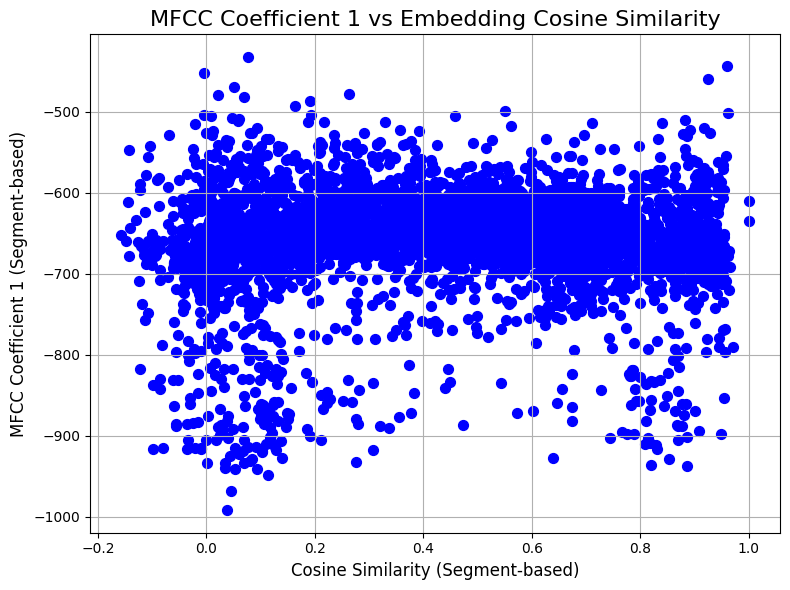

Linear correlation: 0.0723646947030795
Non-linear correlation: -0.004177850018113508


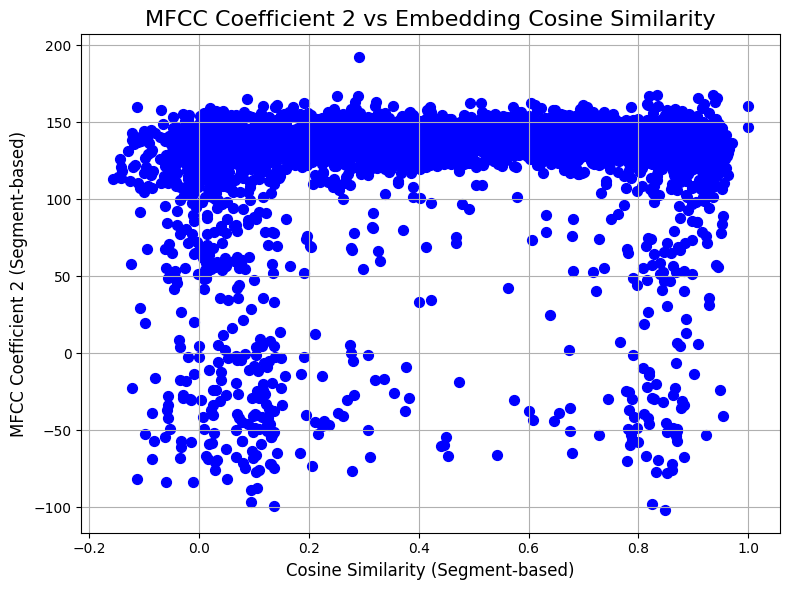

Linear correlation: 0.17438033398312866
Non-linear correlation: 0.12362717609256445


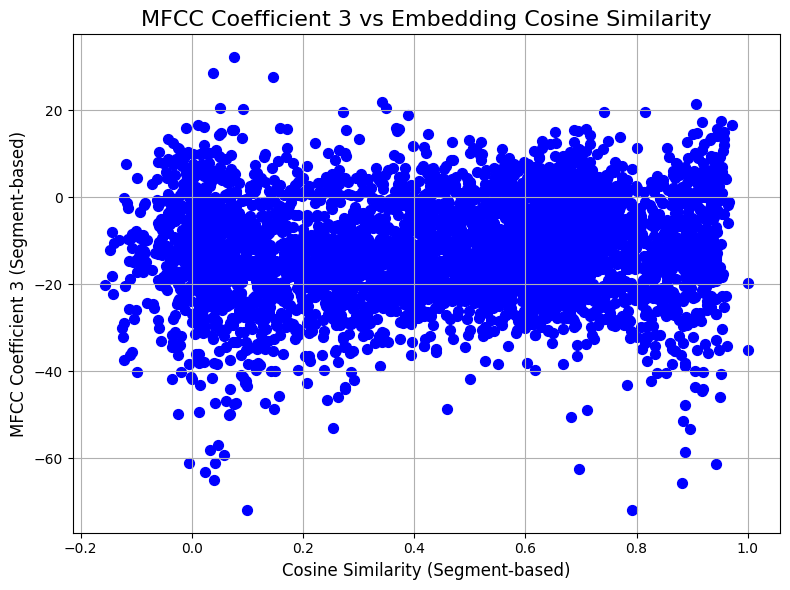

Linear correlation: 0.10702276840102273
Non-linear correlation: 0.11784063746490987


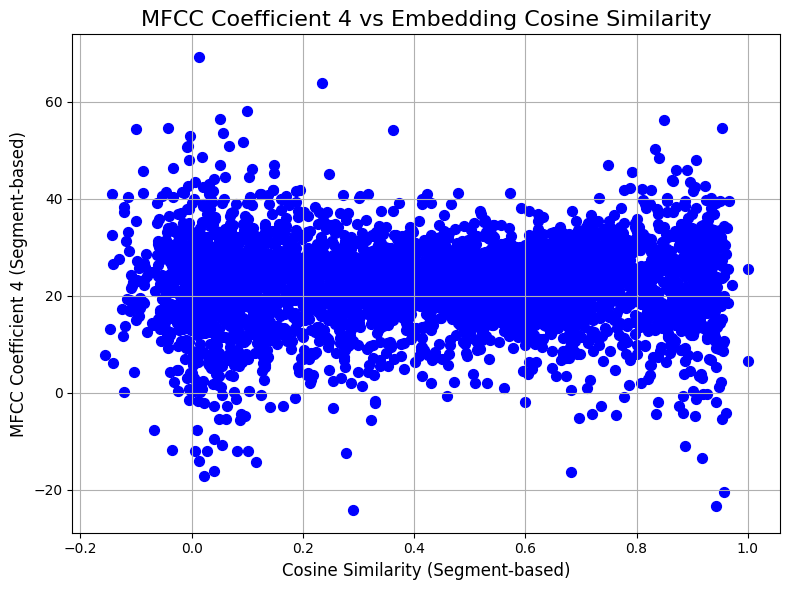

Linear correlation: 0.036735831871215374
Non-linear correlation: 0.0441341567173499


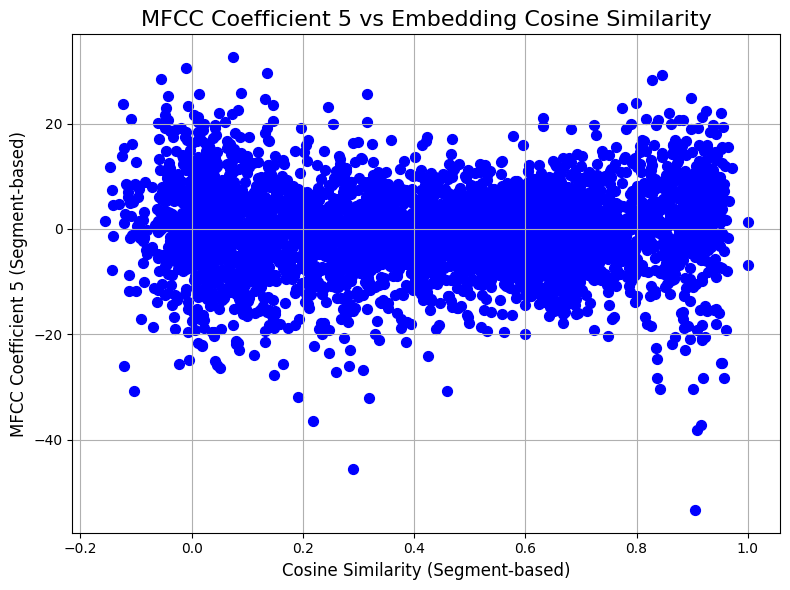

Linear correlation: -0.0006991472350671106
Non-linear correlation: 0.0159350335451661


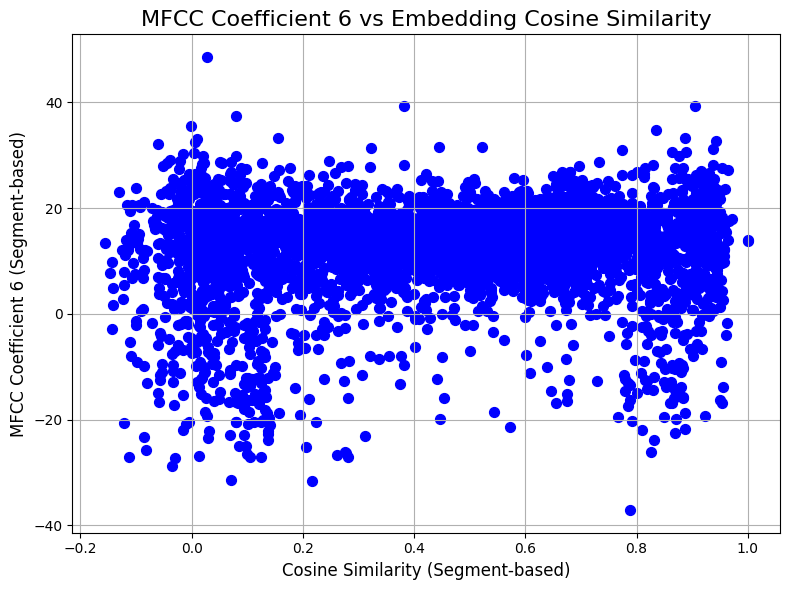

Linear correlation: 0.12556003331207086
Non-linear correlation: 0.09790939506370076


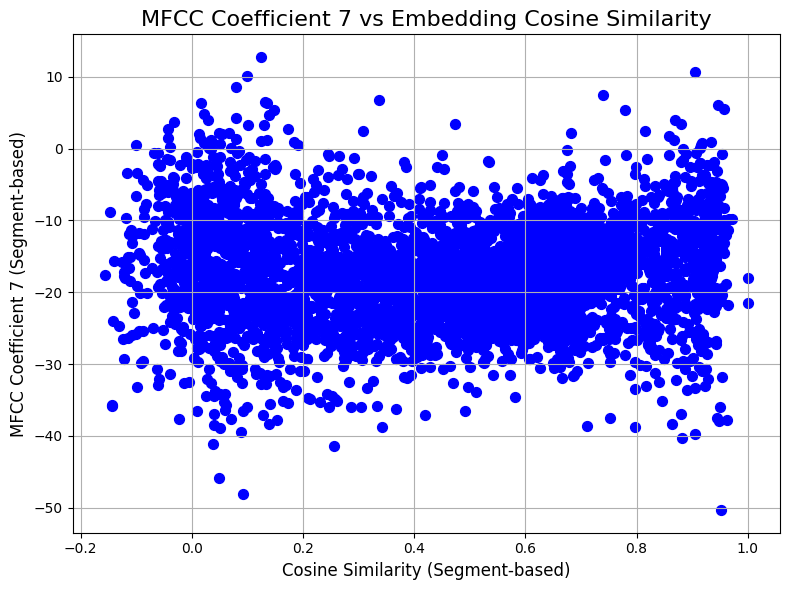

Linear correlation: 0.033662002620594676
Non-linear correlation: 0.07443857151627109


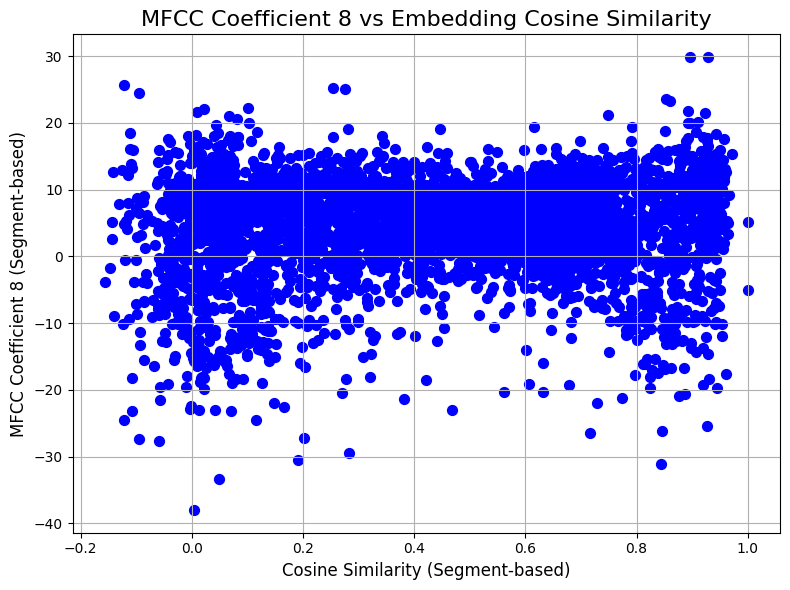

Linear correlation: 0.11041851384274434
Non-linear correlation: 0.06881461074434715


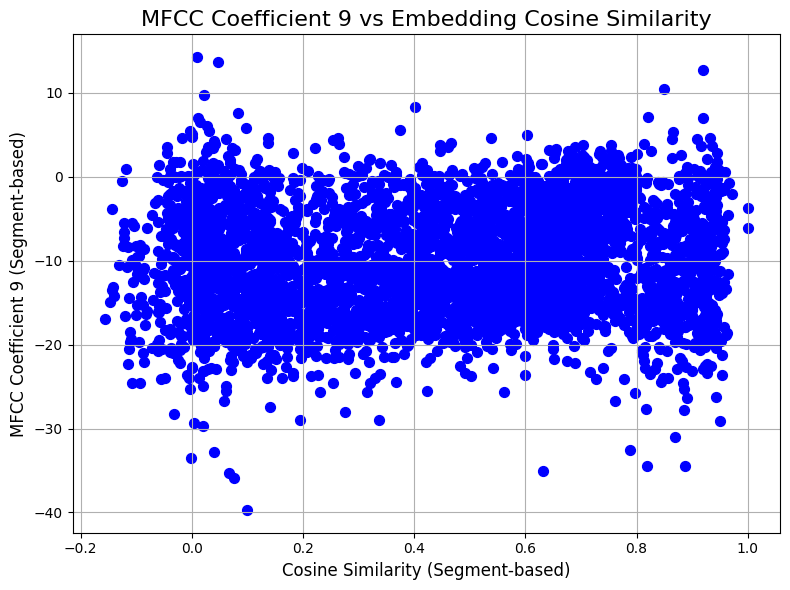

Linear correlation: 0.10933290788901154
Non-linear correlation: 0.12616858724297011


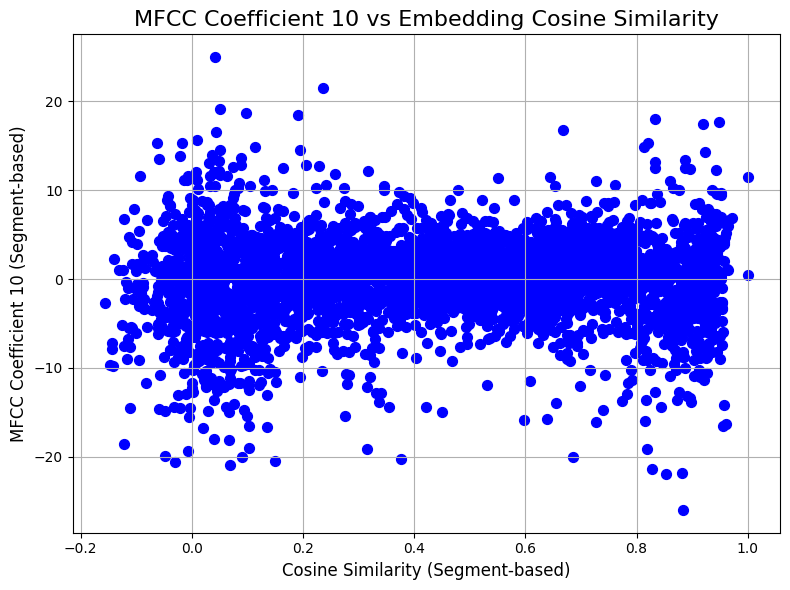

Linear correlation: 0.07302001754796485
Non-linear correlation: 0.0752371174677


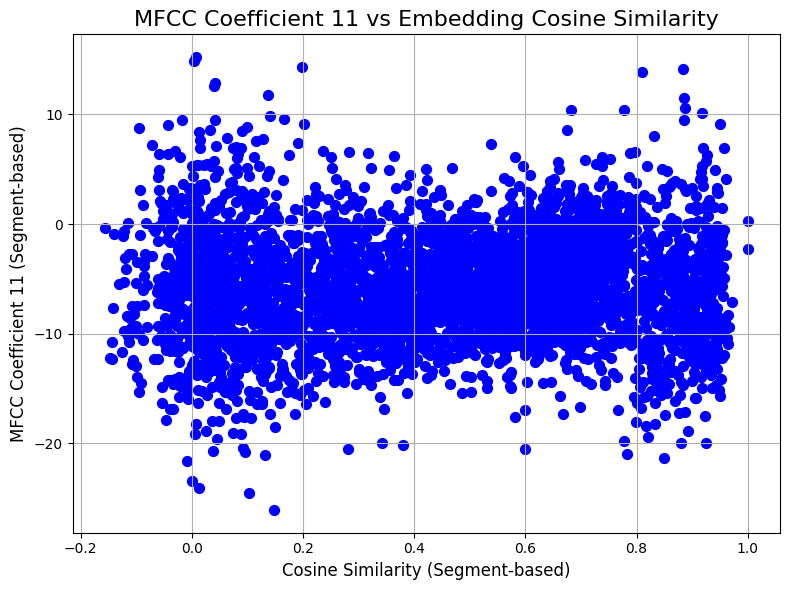

Linear correlation: 0.05459541316395413
Non-linear correlation: 0.07273763237043371


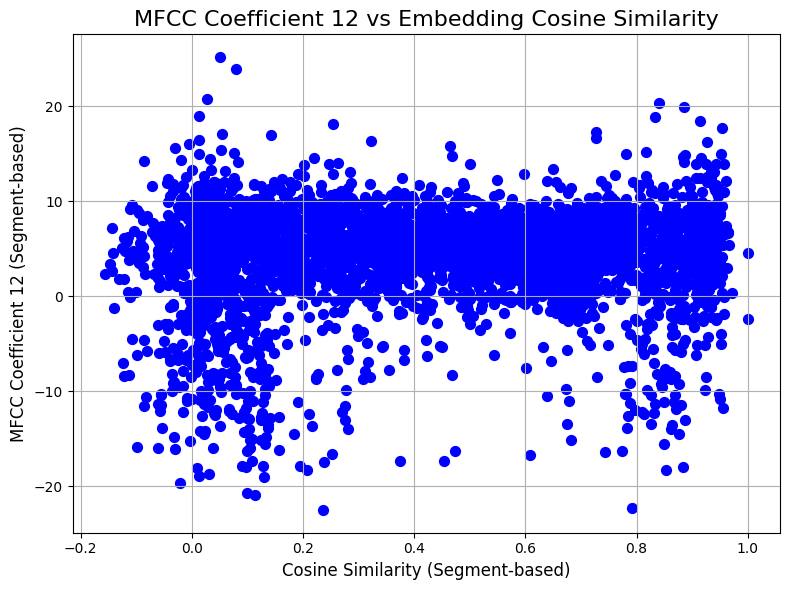

Linear correlation: 0.10692382306883659
Non-linear correlation: 0.03242833213851373


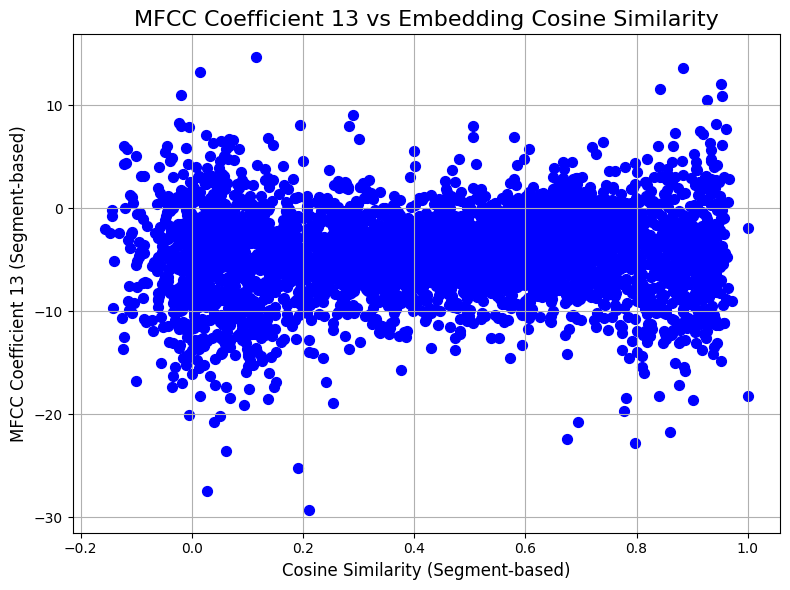

Linear correlation: 0.11728695499036979
Non-linear correlation: 0.1231642836292702


In [33]:
#segment based analysis with mfcc 1
#coefficientwise analysis: use the mean mfcc vector of each segment
#13 plots for 13 coefficients

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

seg_mean_mfcc_vector = np.array(seg_mean_mfcc_vector)
seg_cos_sim = np.array(seg_cos_sim)

for coeff_idx in range(13):
    plt.figure(figsize=(8, 6))

    plt.scatter(seg_cos_sim, seg_mean_mfcc_vector[:, coeff_idx], color='b', s=50)

    plt.title(f"MFCC Coefficient {coeff_idx + 1} vs Embedding Cosine Similarity", fontsize=16)
    plt.xlabel("Cosine Similarity (Segment-based)", fontsize=12)
    plt.ylabel(f"MFCC Coefficient {coeff_idx + 1} (Segment-based)", fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #calculate the linear correlation level (pearson correlation)
    pearson_corr, pearson_p_value = pearsonr(seg_mean_mfcc_vector[:, coeff_idx], seg_cos_sim)
    print(f'Linear correlation: {pearson_corr}')

    #calculate the none-linear correlation level (spearman’s rank correlation)
    spearman_corr, spearman_p_value = spearmanr(seg_mean_mfcc_vector[:, coeff_idx], seg_cos_sim)
    print(f"Non-linear correlation: {spearman_corr}")

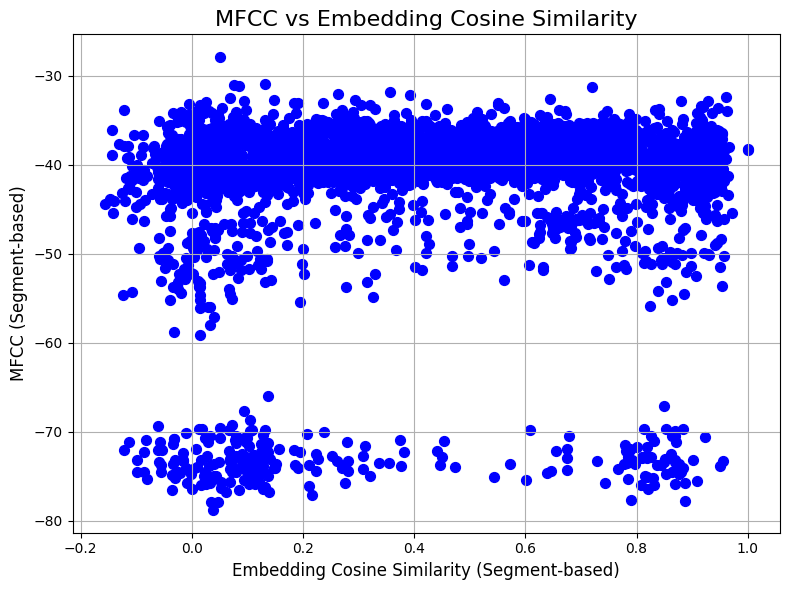

Linear correlation: 0.16575492789531035
Non-linear correlation: 0.12711658909273468


In [36]:
#segment based analysis with mfcc 2
#use the mean value of the mean mfcc vector of each segment

seg_mean_mfcc_value = np.array(seg_mean_mfcc_value)
seg_cos_sim = np.array(seg_cos_sim)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim, seg_mean_mfcc_value, color='b', s=50)

plt.title(f"MFCC vs Embedding Cosine Similarity", fontsize=16)
plt.xlabel("Embedding Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"MFCC (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(seg_mean_mfcc_value, seg_cos_sim)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_mfcc_value, seg_cos_sim)
print(f"Non-linear correlation: {spearman_corr}")

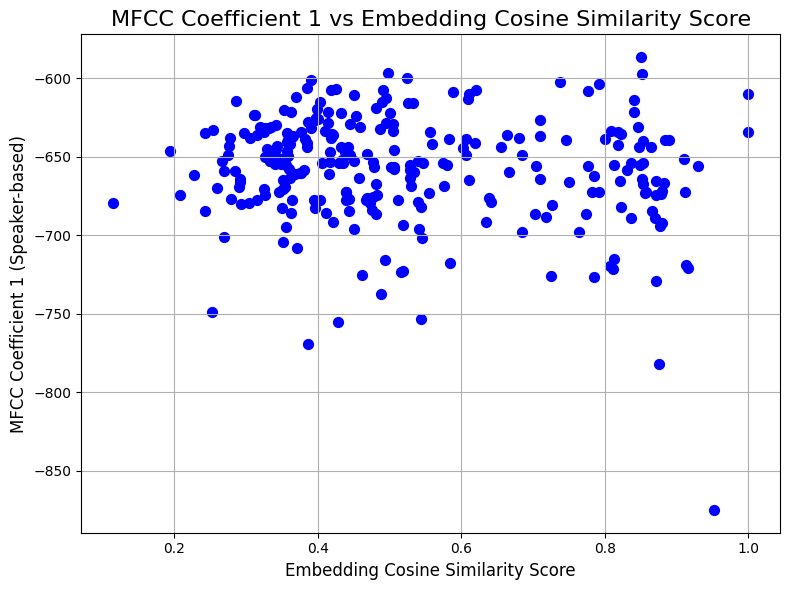

Linear correlation: -0.1451663741521146
Non-linear correlation: -0.11703056294626712


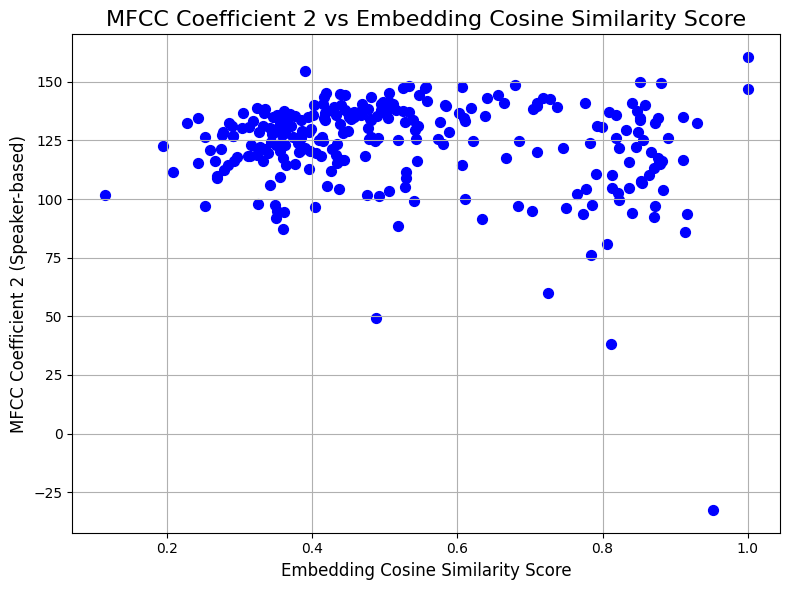

Linear correlation: -0.15802075483491357
Non-linear correlation: 0.013190075065431234


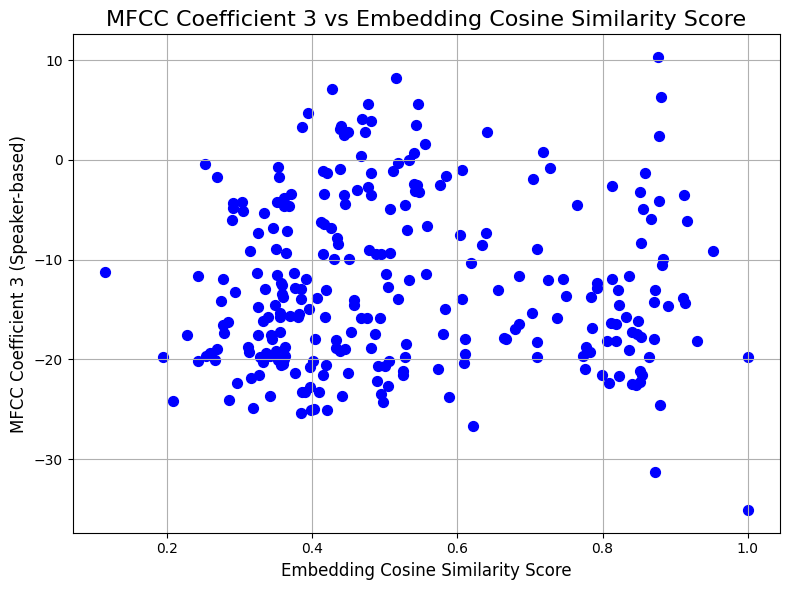

Linear correlation: -0.006292452632500031
Non-linear correlation: 0.062150902936188225


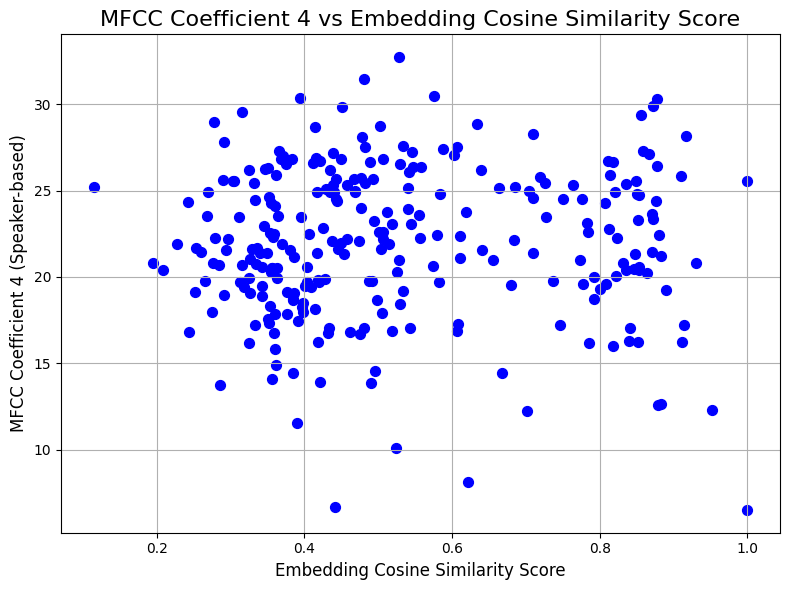

Linear correlation: 0.008180904621174469
Non-linear correlation: 0.07663399847966926


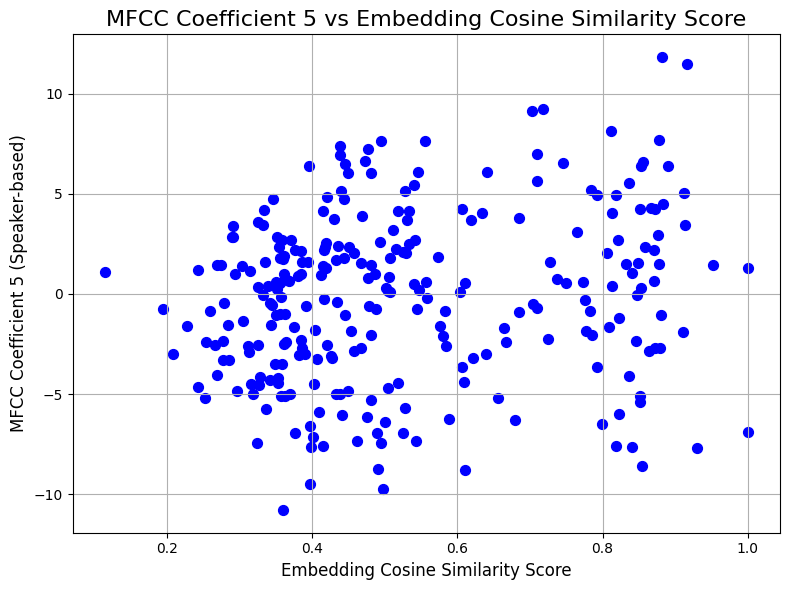

Linear correlation: 0.18334899037475844
Non-linear correlation: 0.18707042831416598


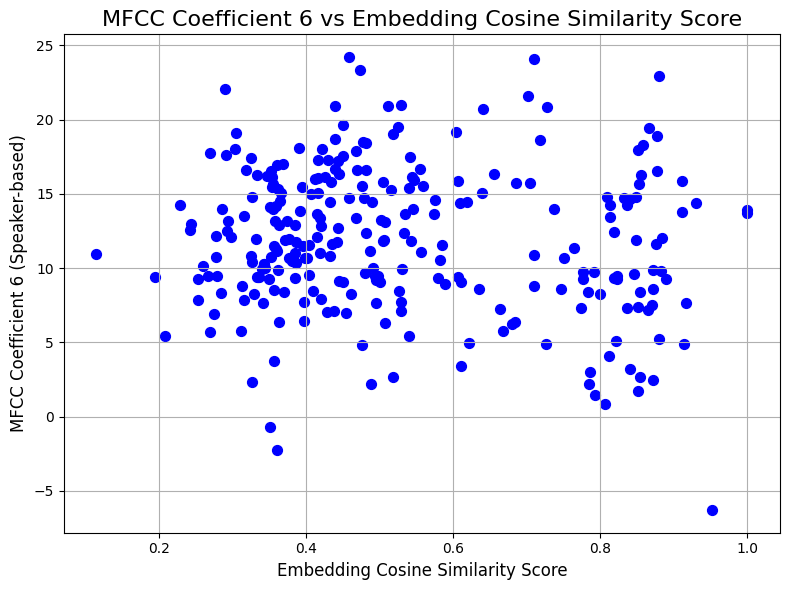

Linear correlation: -0.10690949284391905
Non-linear correlation: -0.05677502483766085


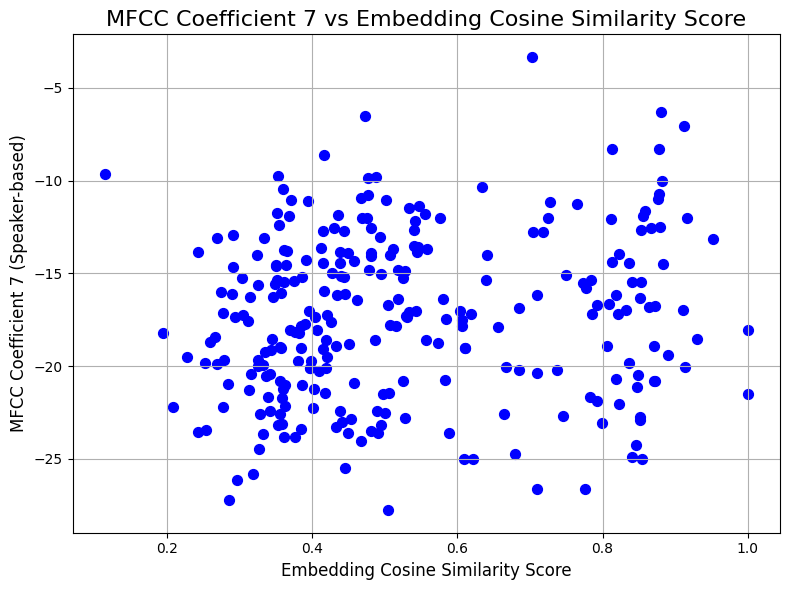

Linear correlation: 0.1271170690207244
Non-linear correlation: 0.15020713500698607


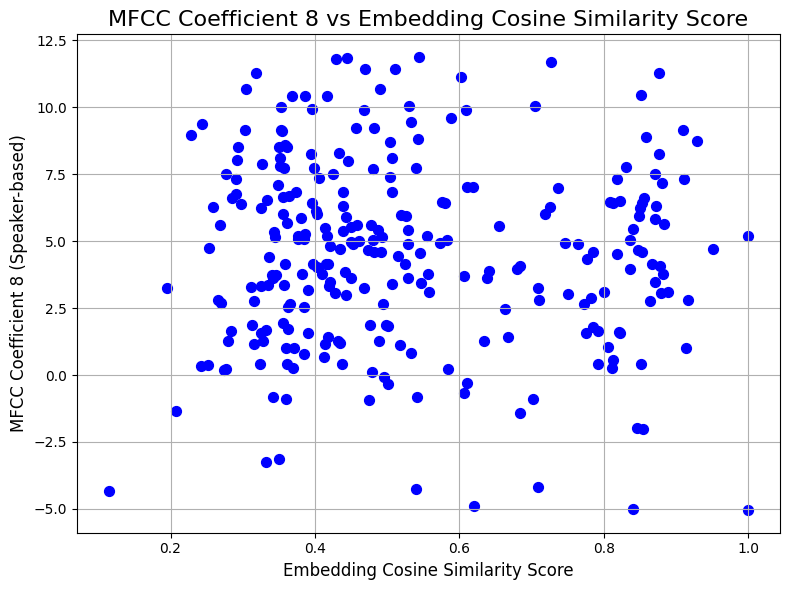

Linear correlation: -0.03883015542180367
Non-linear correlation: -0.010862397026022878


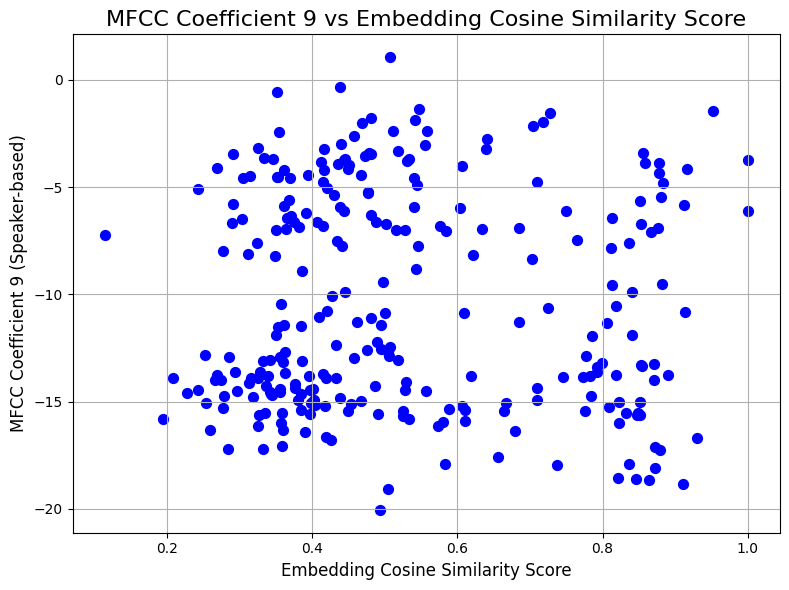

Linear correlation: -0.021561401460803813
Non-linear correlation: 0.013187361802595504


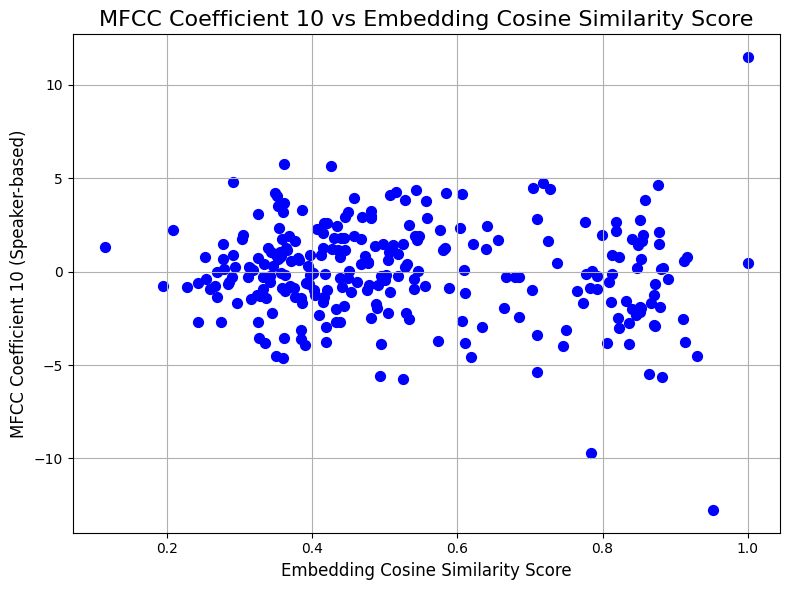

Linear correlation: -0.11167738165044627
Non-linear correlation: -0.06554006969166404


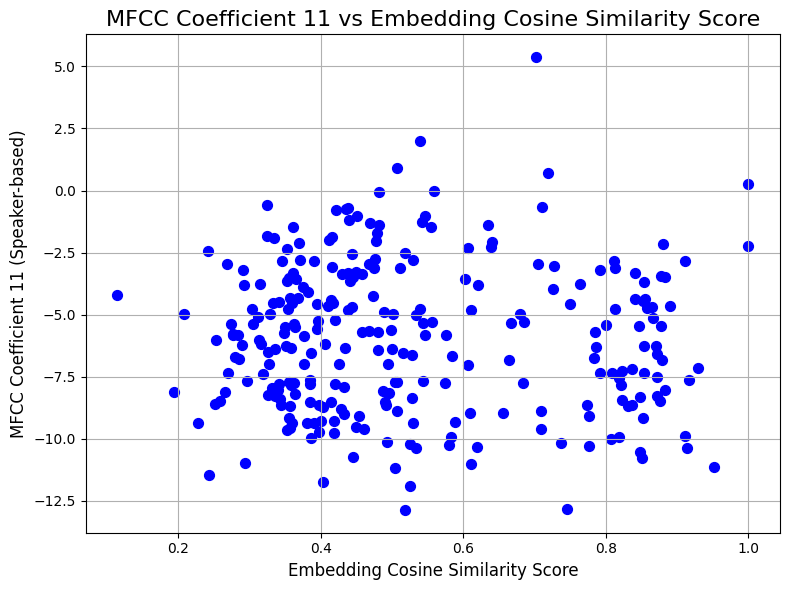

Linear correlation: -0.02729294641635615
Non-linear correlation: -0.020326559270699297


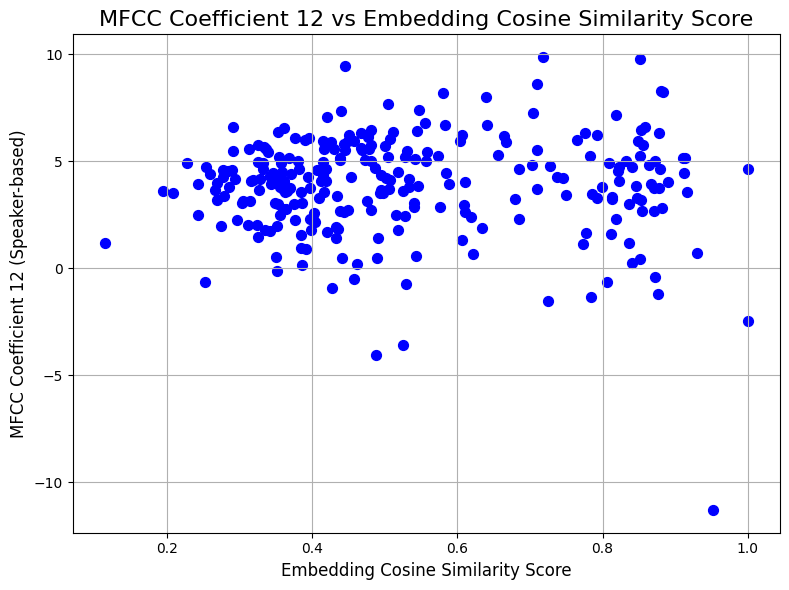

Linear correlation: -0.01355598749839449
Non-linear correlation: 0.08106053605933937


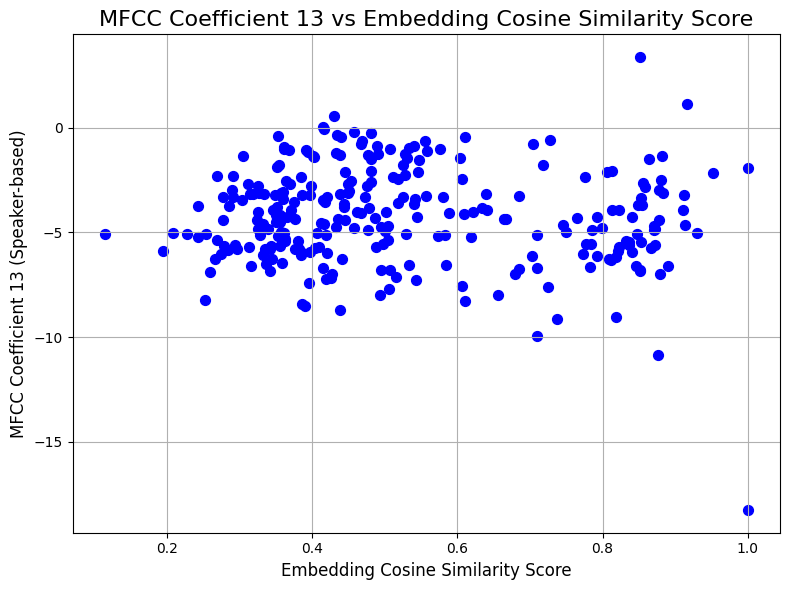

Linear correlation: -0.09215484725907526
Non-linear correlation: -0.010385465714231136


In [35]:
#speaker based analysis with mfcc 1
#use the mean mfcc vector for each speaker
#13 plots
speaker_mean_mfcc_vector = np.array(speaker_mean_mfcc_vector)
speaker_cos_sim = np.array(speaker_cos_sim)

for coeff_idx in range(13):
    plt.figure(figsize=(8, 6))

    plt.scatter(speaker_cos_sim, speaker_mean_mfcc_vector[:, coeff_idx], color='b', s=50)

    plt.title(f"MFCC Coefficient {coeff_idx + 1} vs Embedding Cosine Similarity Score", fontsize=16)
    plt.xlabel("Embedding Cosine Similarity Score", fontsize=12)
    plt.ylabel(f"MFCC Coefficient {coeff_idx + 1} (Speaker-based)", fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #calculate the linear correlation level (pearson correlation)
    pearson_corr, pearson_p_value = pearsonr(speaker_mean_mfcc_vector[:, coeff_idx], speaker_cos_sim)
    print(f'Linear correlation: {pearson_corr}')

    #calculate the none-linear correlation level (spearman’s rank correlation)
    spearman_corr, spearman_p_value = spearmanr(speaker_mean_mfcc_vector[:, coeff_idx], speaker_cos_sim)
    print(f"Non-linear correlation: {spearman_corr}")

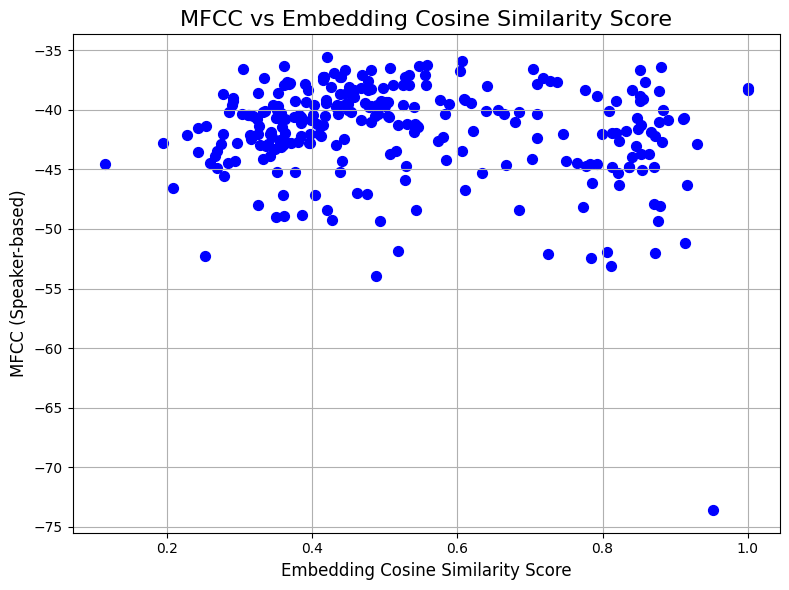

Linear correlation: -0.15362715947197694
Non-linear correlation: -0.008416842790084447


In [37]:
#speaker based analysis with mfcc 2
#use the mean mfcc value for each speaker

speaker_mean_mfcc_value = np.array(speaker_mean_mfcc_value)
speaker_cos_sim = np.array(speaker_cos_sim)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim, speaker_mean_mfcc_value, color='b', s=50)

plt.title(f"MFCC vs Embedding Cosine Similarity Score", fontsize=16)
plt.xlabel("Embedding Cosine Similarity Score", fontsize=12)
plt.ylabel(f"MFCC (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(speaker_mean_mfcc_value, speaker_cos_sim)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_mfcc_value, speaker_cos_sim)
print(f"Non-linear correlation: {spearman_corr}")

STEP 3.2: conduct correlation analysis between xvectors and the mean cosine similarites of embeddings

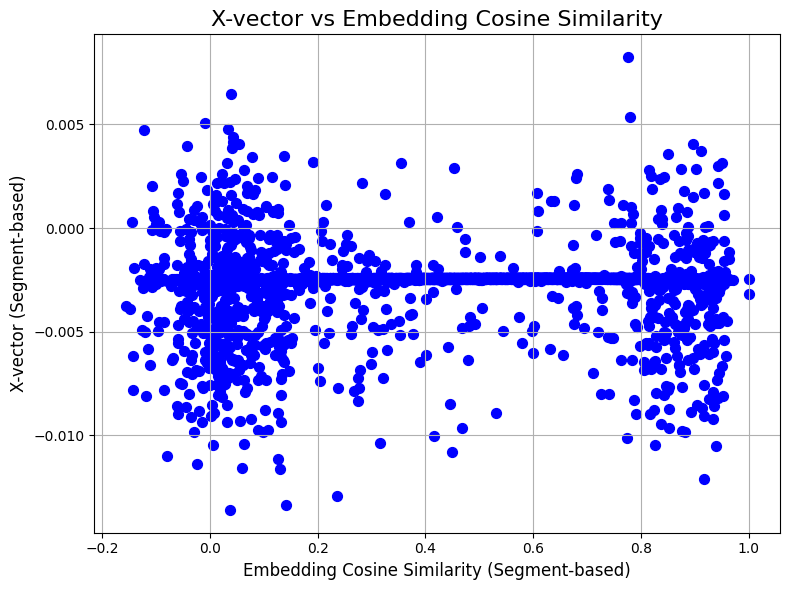

Linear correlation: 0.051666015770505606
Non-linear correlation: 0.23693903660550245


In [39]:
#segment based analysis with xvector
#no coefficientwise analysis due to the large number of coefficients (512)
#use the mean vector value of each segment

seg_mean_xvector_value = np.array(seg_mean_xvector_value)
seg_cos_sim = np.array(seg_cos_sim)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim, seg_mean_xvector_value, color='b', s=50)

plt.title(f"X-vector vs Embedding Cosine Similarity", fontsize=16)
plt.xlabel("Embedding Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"X-vector (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
seg_mean_xvector_value = np.ravel(seg_mean_xvector_value)
seg_cos_sim = np.ravel(seg_cos_sim)

pearson_corr, pearson_p_value = pearsonr(seg_mean_xvector_value, seg_cos_sim)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_xvector_value, seg_cos_sim)
print(f"Non-linear correlation: {spearman_corr}")



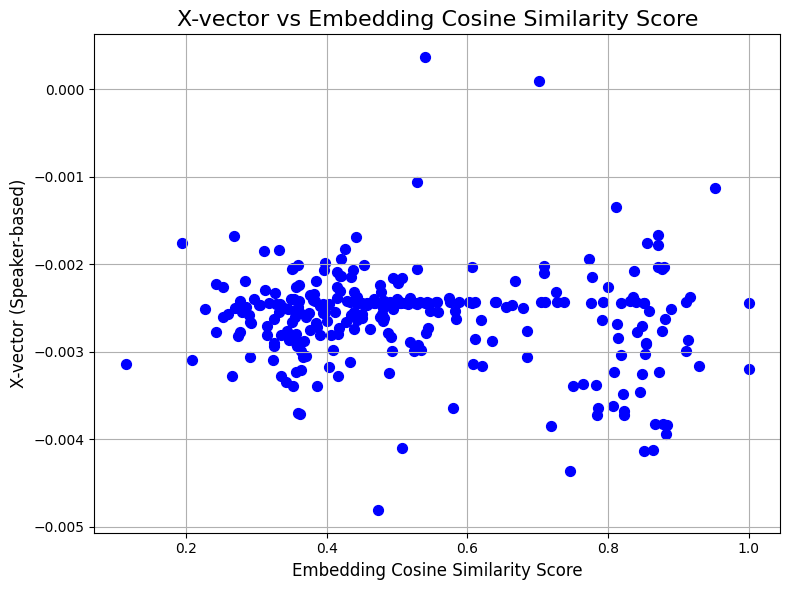

Linear correlation: -0.11488531445134055
Non-linear correlation: -0.037283246099421304


In [41]:
#speaker based analysis with xvector
#use the mean xvector value for each speaker

speaker_mean_xvector_value = np.array(speaker_mean_xvector_value)
speaker_cos_sim = np.array(speaker_cos_sim)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim, speaker_mean_xvector_value, color='b', s=50)

plt.title(f"X-vector vs Embedding Cosine Similarity Score", fontsize=16)
plt.xlabel("Embedding Cosine Similarity Score", fontsize=12)
plt.ylabel(f"X-vector (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
speaker_mean_xvector_value = np.ravel(speaker_mean_xvector_value)
speaker_cos_sim = np.ravel(speaker_cos_sim)

pearson_corr, pearson_p_value = pearsonr(speaker_mean_xvector_value, speaker_cos_sim)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_xvector_value, speaker_cos_sim)
print(f"Non-linear correlation: {spearman_corr}")

STEP 3.3: conduct correlation analysis between embeddings and the mean cosine similarites of embeddings

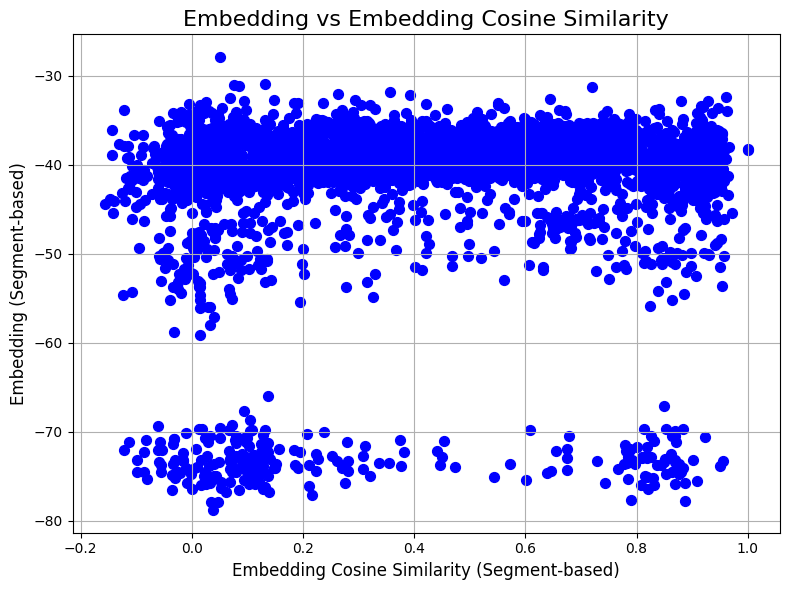

Linear correlation: 0.08606078137037237
Non-linear correlation: 0.05288248478780221


In [46]:
#segment based analysis with embedding

seg_mean_embedding_value = np.array(seg_mean_embedding_value)
seg_cos_sim = np.array(seg_cos_sim)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim, seg_mean_mfcc_value, color='b', s=50)

plt.title(f"Embedding vs Embedding Cosine Similarity", fontsize=16)
plt.xlabel("Embedding Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"Embedding (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(seg_mean_embedding_value, seg_cos_sim)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_embedding_value, seg_cos_sim)
print(f"Non-linear correlation: {spearman_corr}")

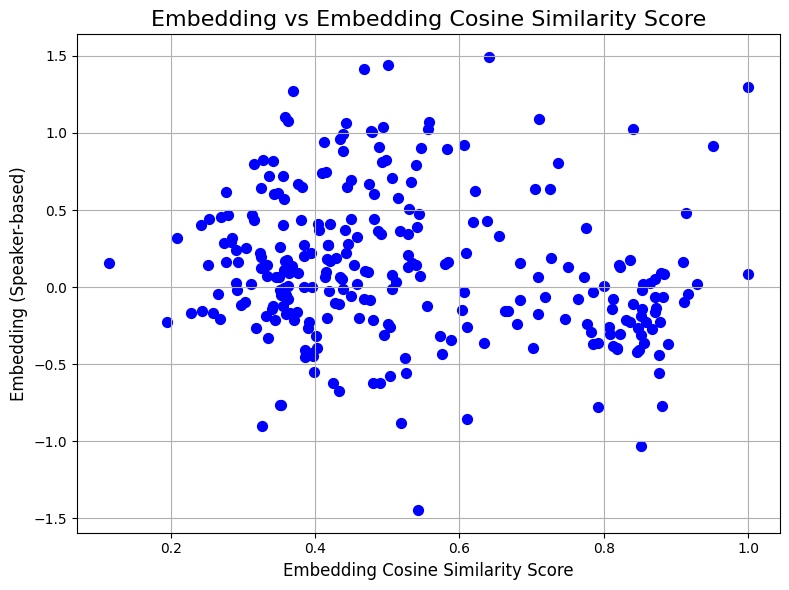

Linear correlation: -0.17306419053265215
Non-linear correlation: -0.1922310542277254


In [47]:
#speaker based analysis with embedding

speaker_mean_embedding_value = np.array(speaker_mean_embedding_value)
speaker_cos_sim = np.array(speaker_cos_sim)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim, speaker_mean_embedding_value, color='b', s=50)

plt.title(f"Embedding vs Embedding Cosine Similarity Score", fontsize=16)
plt.xlabel("Embedding Cosine Similarity Score", fontsize=12)
plt.ylabel(f"Embedding (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(speaker_mean_embedding_value, speaker_cos_sim)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_embedding_value, speaker_cos_sim)
print(f"Non-linear correlation: {spearman_corr}")

STEP 4: prepare data for correlation analysis 2 and 3

Analysis 2 is the analysis between speech features and the mean cosine similarities of MFCCs
Analysis 3 is the analysis between speech features and the mean cosine similarities of x-vectors

STEP 4.1: prepare the MFCC parameters that will be used for analysis

In [ ]:
#obtain the mfcc based speaker centroid
#according to how the speaker centriod is calculated in the paper (Chowdhury et al. (2024)), the mfcc based speaker centriod is actually the mean mfcc vector for each speaker

mfcc_speaker_centroid = [mfcc_speaker_vec for mfcc_speaker_vec in add_mean_xvector_df["speaker_mfcc_vector"]]
mfcc_speaker_centroid = np.array(mfcc_speaker_centroid)

add_mean_xvector_df["speaker_centroid_mfcc"] = add_mean_xvector_df["speaker_mfcc_vector"]

In [ ]:
#calculate the segment based mean cosine similarities of mfccs
#calculate the cosine similarities of each mfcc of selected segments

add_mean_xvector_df['seg_cos_sim_mfcc'] = None

for index, data in add_mean_xvector_df.iterrows():
    speaker_centroid = data['speaker_centroid_mfcc']

    seg_cos_sim_list = []

    for mfcc_per_segment in data['mfccs']:
        cosine_similarities = []

        for mfcc_per_frame in mfcc_per_segment.T:
            cos_sim = cosine_similarity([mfcc_per_frame], [speaker_centroid])[0][0]
            cosine_similarities.append(cos_sim)

        seg_cos_sim = np.mean(cosine_similarities)
        seg_cos_sim_list.append(seg_cos_sim)

    add_mean_xvector_df.at[index,'seg_cos_sim_mfcc'] = seg_cos_sim_list

In [ ]:
#calculate the speaker level mean cosine similarity (also defined as cosine similarity score by Chowdhury et al. (2024)) of mfccs

add_mean_xvector_df['speaker_cos_sim_mfcc'] = add_mean_xvector_df['seg_cos_sim_mfcc'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

STEP 4.2: prepare x-vector parameters that will be used for analysis

In [ ]:
#obtain the xvector based speaker centroid
#according to Chowdhury et al. (2024), speaker centriod is the average of the embeddings associated with all of the segments assigned to a speaker, in this case, the the xvector based speaker centriod is actually the mean xvector of each speaker

speaker_centroid_xvector = []
for i,data in add_mean_xvector_df.iterrows():
  speaker_seg = np.squeeze(data["xvectors"],axis=1)
  speaker_centroid = np.mean(speaker_seg,axis=0)
  speaker_centroid_xvector.append(speaker_centroid)

add_mean_xvector_df["speaker_centroid_xvector"] = speaker_centroid_xvector

In [ ]:
#calculate the segment based mean cosine similarities of xvectors

#calculate the cosine similarities of each xvector of selected segments

add_mean_xvector_df['seg_cos_sim_xvector'] = None

for index, data in add_mean_xvector_df.iterrows():
    speaker_centroid = data['speaker_centroid_xvector']

    speaker_centroid = np.reshape(speaker_centroid,(1,512))
    seg_cos_sim_list = []
    for xvector_per_segment in data['xvectors']:
        cos_sim = cosine_similarity(xvector_per_segment, speaker_centroid)[0][0]
        seg_cos_sim_list.append(cos_sim)

    add_mean_xvector_df.at[index,'seg_cos_sim_xvector'] = seg_cos_sim_list

In [ ]:
#calculate the speaker based xvector cosine similarity (cosine similarity score)
add_mean_xvector_df['speaker_cos_sim_xvector'] = add_mean_xvector_df['seg_cos_sim_xvector'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

STEP 5: conduct correlation analysis 2, which is the analysis between speech features and the mean cosine similarities of MFCCs

In [ ]:
#prepare data lists for plotting
seg_mean_mfcc_vector = [seg_mfcc for row in add_mean_xvector_df['mean_mfcc_segments'] for seg_mfcc in row]
seg_mean_mfcc_value = [seg_mfcc_value for row in add_mean_xvector_df['mean_mfcc_seg_value'] for seg_mfcc_value in row]

speaker_mean_mfcc_vector = [speaker_mfcc_vector for speaker_mfcc_vector in add_mean_xvector_df['speaker_mfcc_vector']]
speaker_mean_mfcc_value = [speaker_mfcc_value for speaker_mfcc_value in add_mean_xvector_df['speaker_mfcc_value']]

seg_mean_xvector_value = [seg_xvector_value for row in add_mean_xvector_df['seg_mean_xvector_value'] for seg_xvector_value in row]
speaker_mean_xvector_value = [speaker_xvector_value for speaker_xvector_value in add_mean_xvector_df['speaker_mean_xvector_value']]

seg_mean_embedding_value = [seg_embedding_value for row in add_mean_xvector_df['seg_embedding_value'] for seg_embedding_value in row]
speaker_mean_embedding_value = [speaker_embedding_value for speaker_embedding_value in add_mean_xvector_df['speaker_embedding_value']]

seg_cos_sim_mfcc = [seg_cos_sim for row in add_mean_xvector_df['seg_cos_sim_mfcc'] for seg_cos_sim in row]
speaker_cos_sim_mfcc = [speaker_cos_sim for speaker_cos_sim in add_mean_xvector_df['speaker_cos_sim_mfcc']]

seg_cos_sim_xvector = [seg_cos_sim for row in add_mean_xvector_df['seg_cos_sim_xvector'] for seg_cos_sim in row]
speaker_cos_sim_xvector = [speaker_cos_sim for speaker_cos_sim in add_mean_xvector_df['speaker_cos_sim_xvector']]

STEP 5.1: conduct correlation analysis between MFCCs and the mean cosine similarities of MFCCs

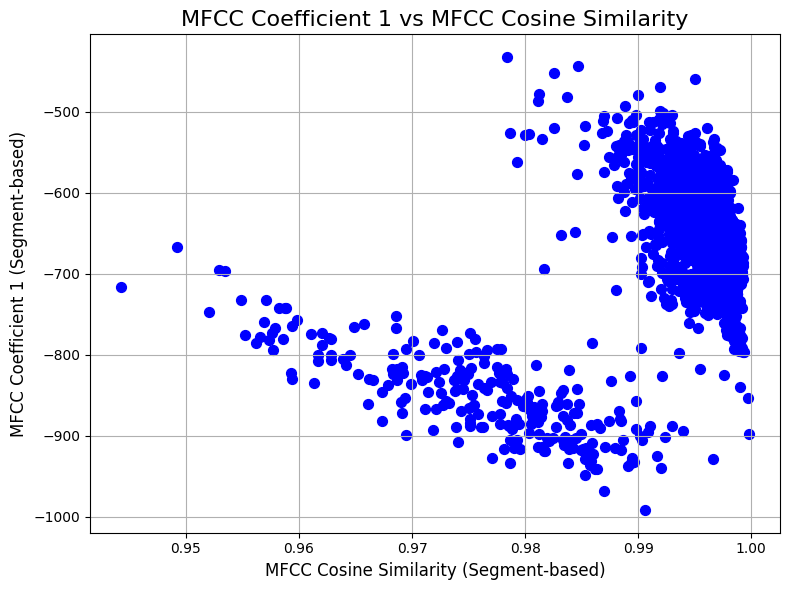

Linear correlation: 0.420959120807433
Non-linear correlation: -0.3059852579820198


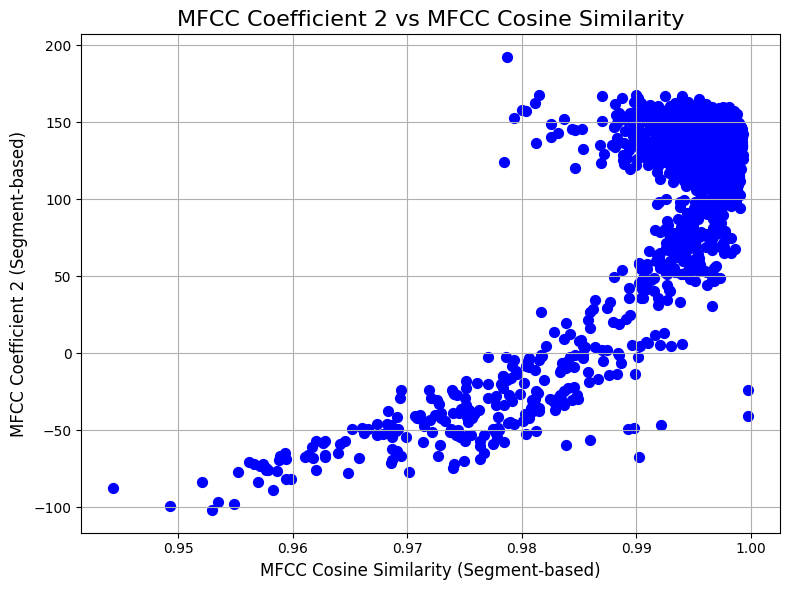

Linear correlation: 0.8195796390429689
Non-linear correlation: 0.06910828190465265


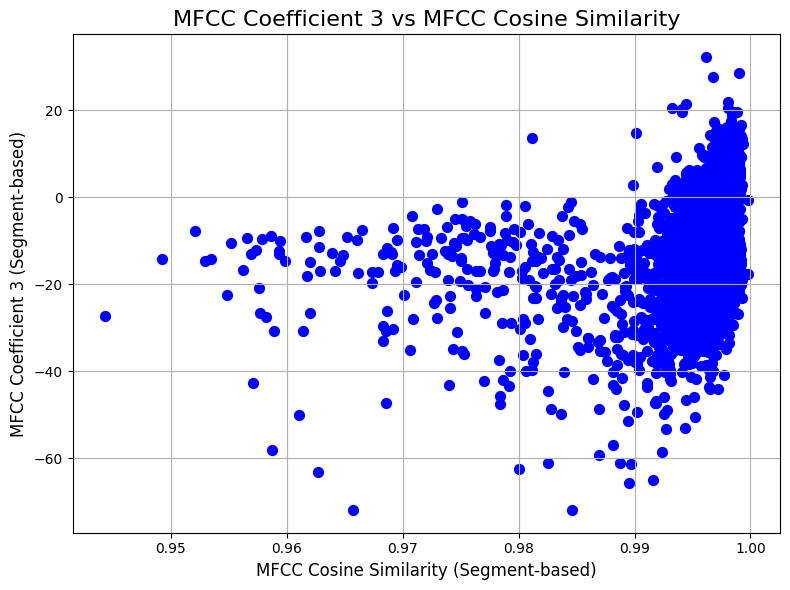

Linear correlation: 0.2566458288861004
Non-linear correlation: 0.335875701404087


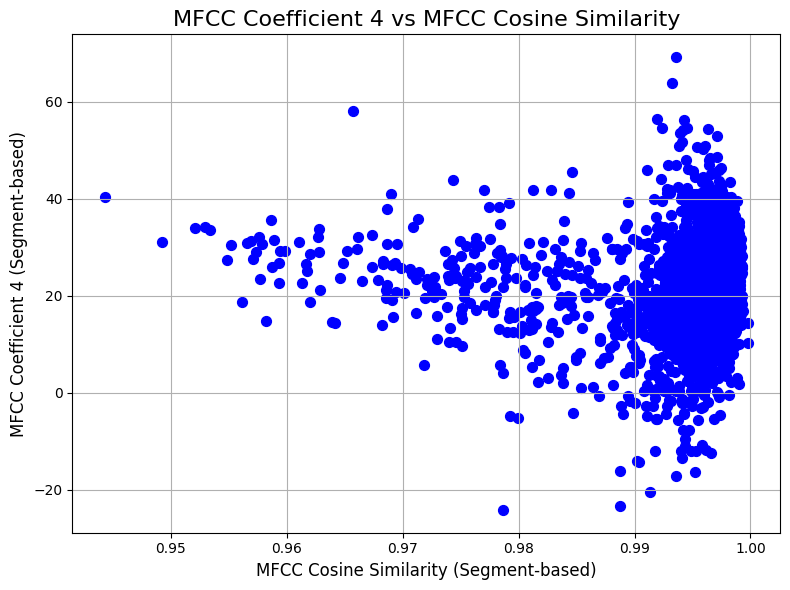

Linear correlation: 0.04505155953198581
Non-linear correlation: 0.16758987014013724


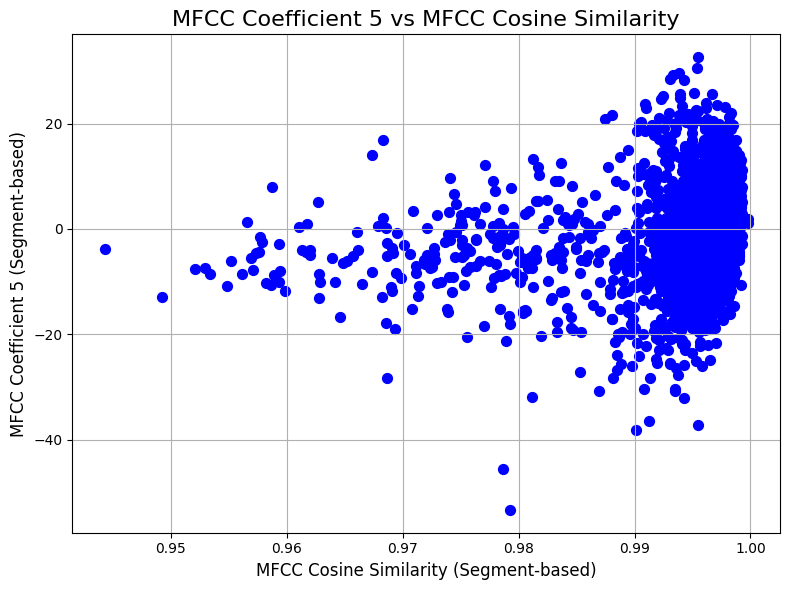

Linear correlation: 0.22769225357194028
Non-linear correlation: 0.3629869191241037


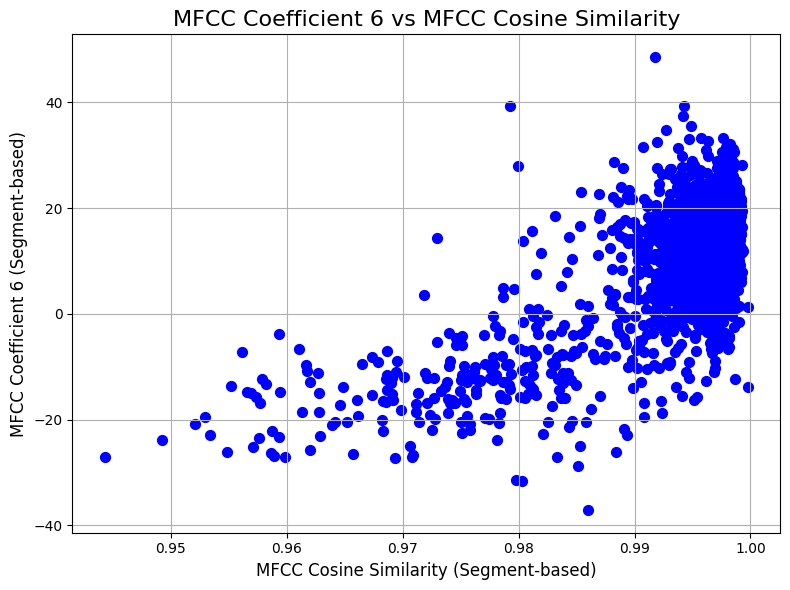

Linear correlation: 0.6506500796872671
Non-linear correlation: 0.3077082970265001


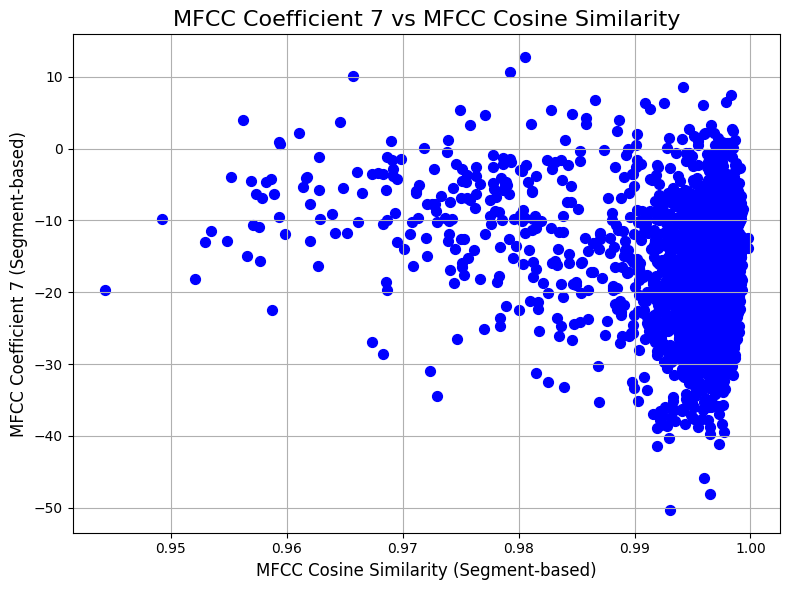

Linear correlation: -0.19959557642140793
Non-linear correlation: 0.03452112534447659


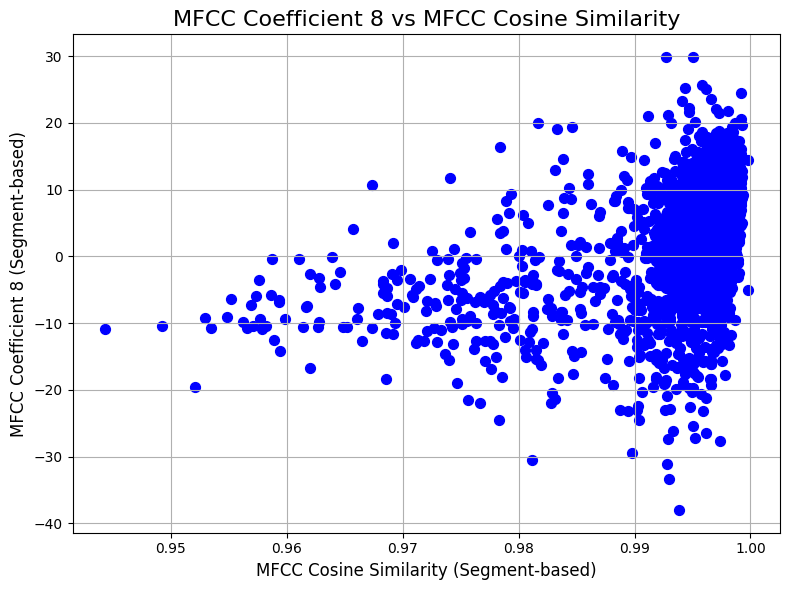

Linear correlation: 0.4463478215670563
Non-linear correlation: 0.47455090918410153


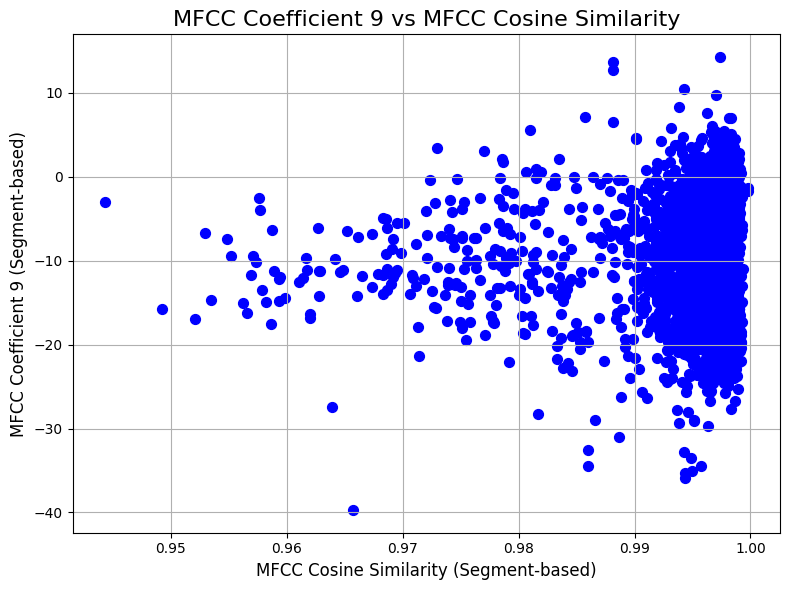

Linear correlation: 0.012687396255133463
Non-linear correlation: -0.04606222298513737


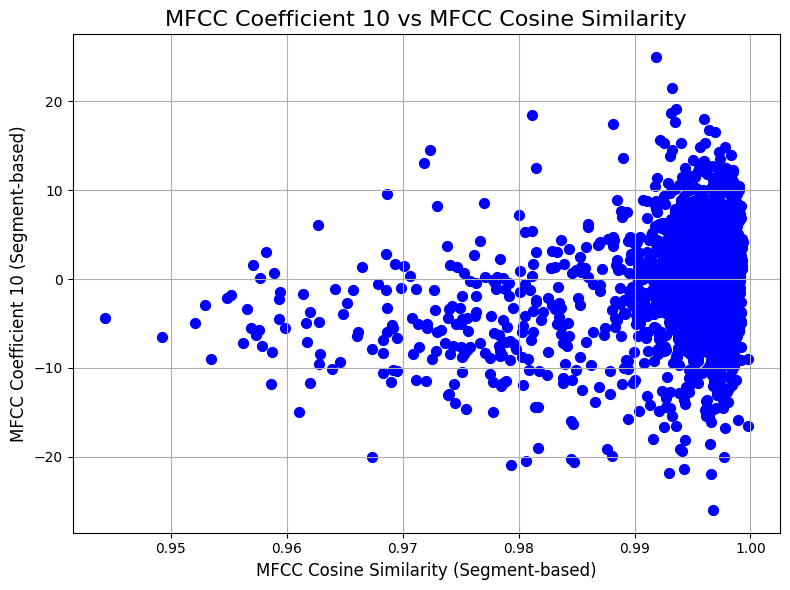

Linear correlation: 0.24262685854285929
Non-linear correlation: 0.13220098955997417


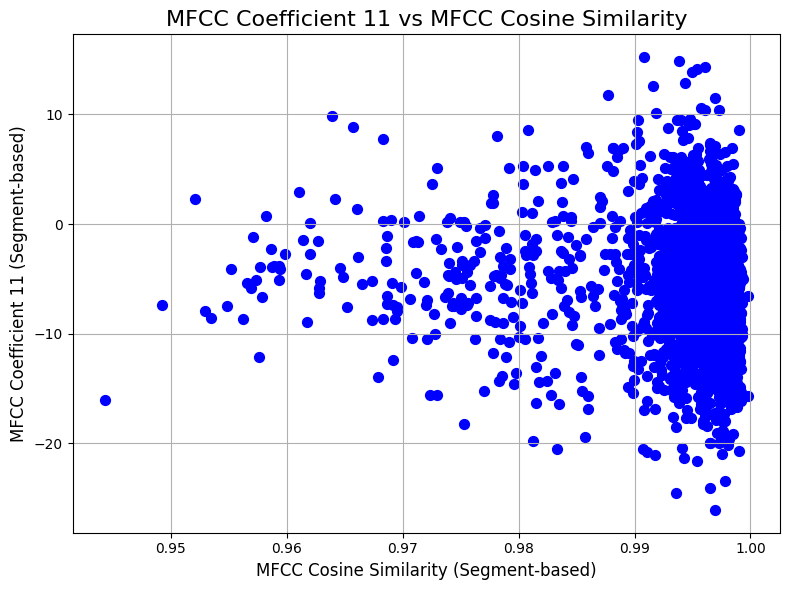

Linear correlation: -0.08083233923793726
Non-linear correlation: -0.14920089644430823


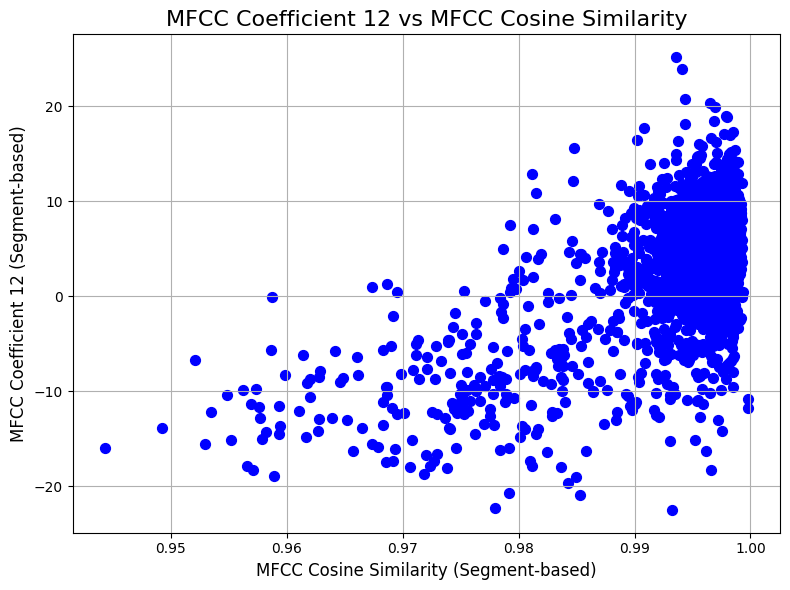

Linear correlation: 0.5885536710180096
Non-linear correlation: 0.26404144549516506


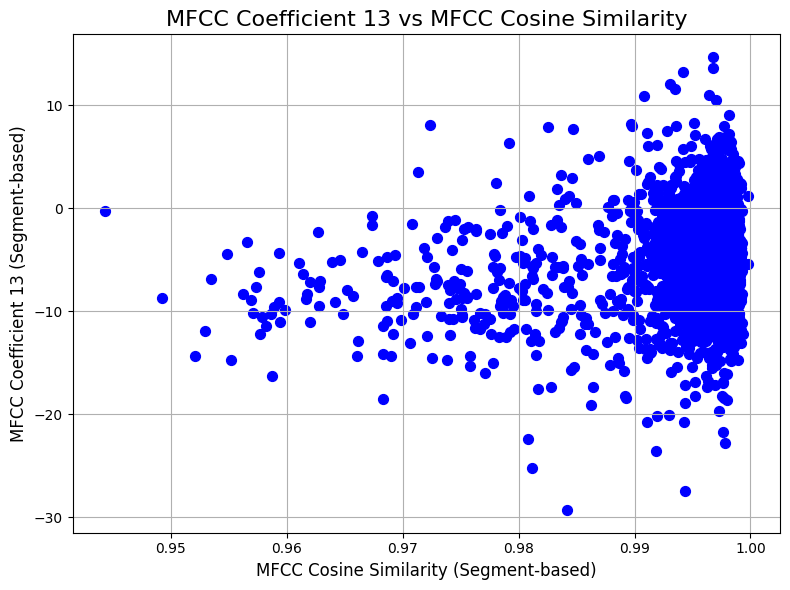

Linear correlation: 0.19985486078110098
Non-linear correlation: 0.061421332456377195


In [59]:
#correlation analysis with mfcc 1
#segment level
#analysis based on each mfcc coefficient,13 in total
seg_mean_mfcc_vector = np.array(seg_mean_mfcc_vector)
seg_cos_sim_mfcc = np.array(seg_cos_sim_mfcc)

for coeff_idx in range(13):
    plt.figure(figsize=(8, 6))

    plt.scatter(seg_cos_sim_mfcc, seg_mean_mfcc_vector[:, coeff_idx], color='b', s=50)

    plt.title(f"MFCC Coefficient {coeff_idx + 1} vs MFCC Cosine Similarity", fontsize=16)
    plt.xlabel("MFCC Cosine Similarity (Segment-based)", fontsize=12)
    plt.ylabel(f"MFCC Coefficient {coeff_idx + 1} (Segment-based)", fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #calculate the linear correlation level (pearson correlation)
    pearson_corr, pearson_p_value = pearsonr(seg_mean_mfcc_vector[:, coeff_idx], seg_cos_sim_mfcc)
    print(f'Linear correlation: {pearson_corr}')

    #calculate the none-linear correlation level (spearman’s rank correlation)
    spearman_corr, spearman_p_value = spearmanr(seg_mean_mfcc_vector[:, coeff_idx], seg_cos_sim_mfcc)
    print(f"Non-linear correlation: {spearman_corr}")

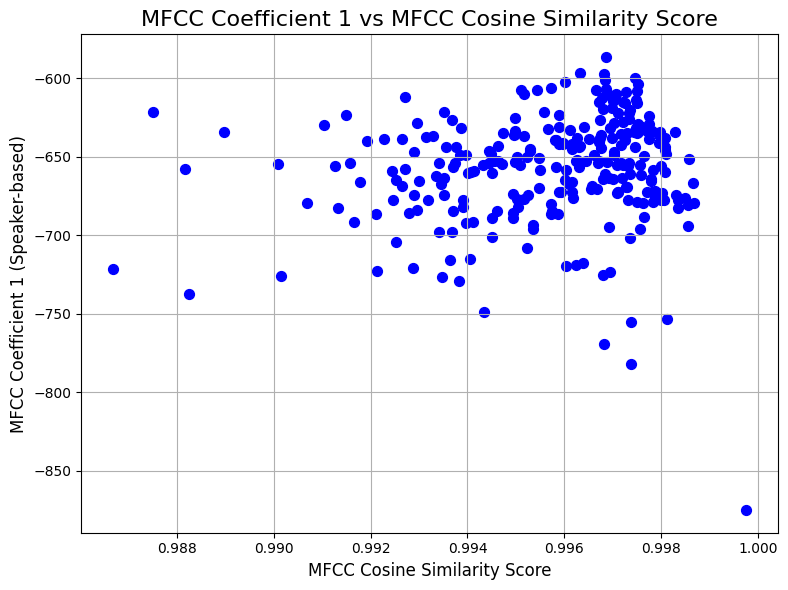

Linear correlation: 0.12393087782798587
Non-linear correlation: 0.14699611701999374


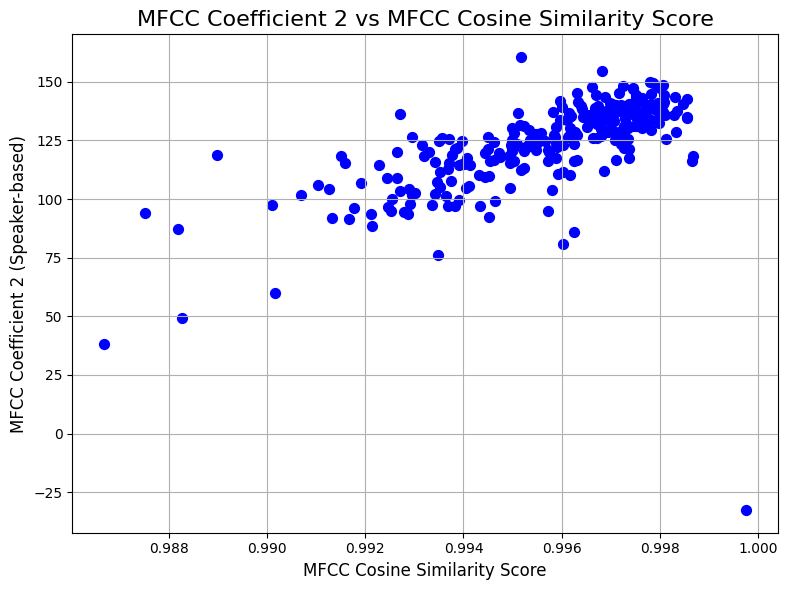

Linear correlation: 0.6162975127904123
Non-linear correlation: 0.7362413477075948


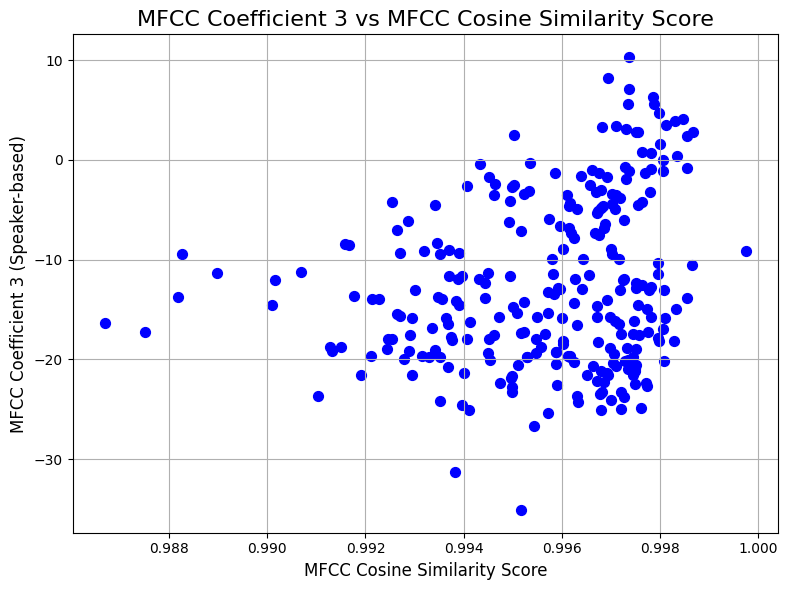

Linear correlation: 0.2195612030339198
Non-linear correlation: 0.20282541060704726


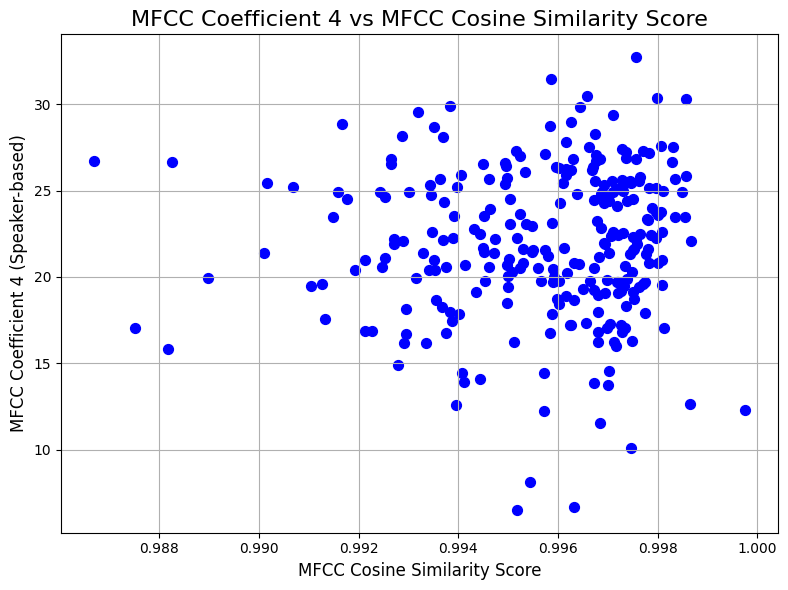

Linear correlation: 0.04593033754742532
Non-linear correlation: 0.0806508212140945


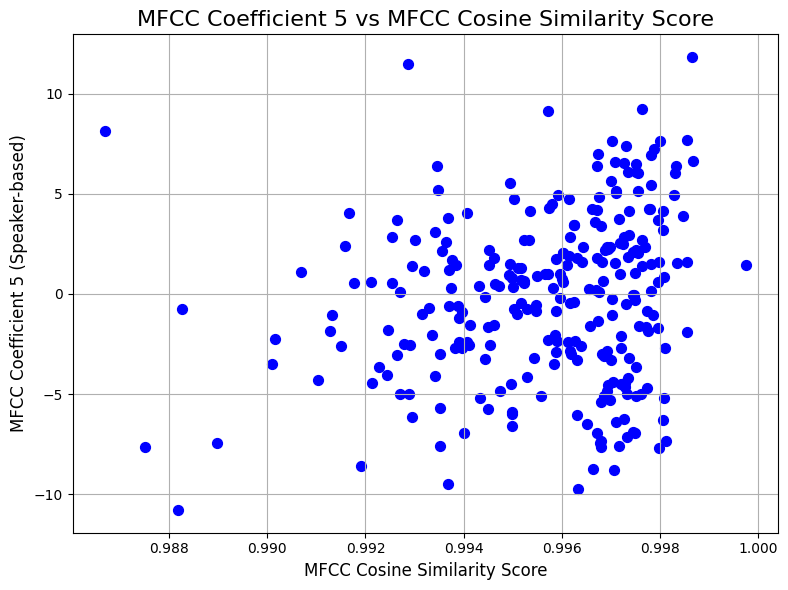

Linear correlation: 0.18927734323710876
Non-linear correlation: 0.19547246943057664


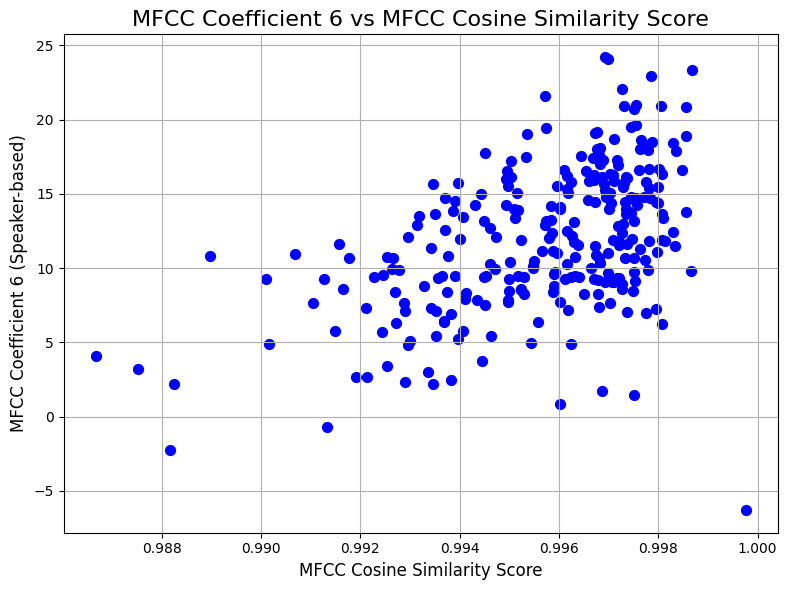

Linear correlation: 0.48462972306715973
Non-linear correlation: 0.4717688059233534


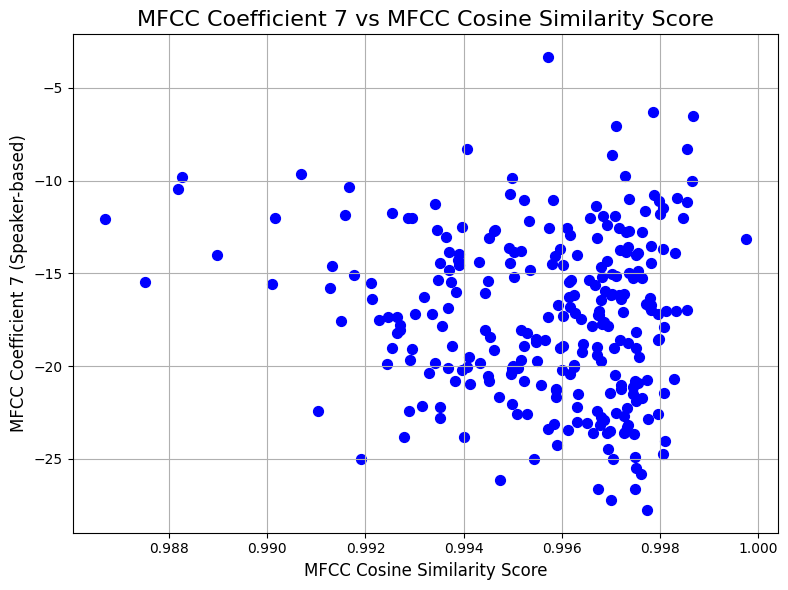

Linear correlation: -0.10133984399235478
Non-linear correlation: -0.03648433543158961


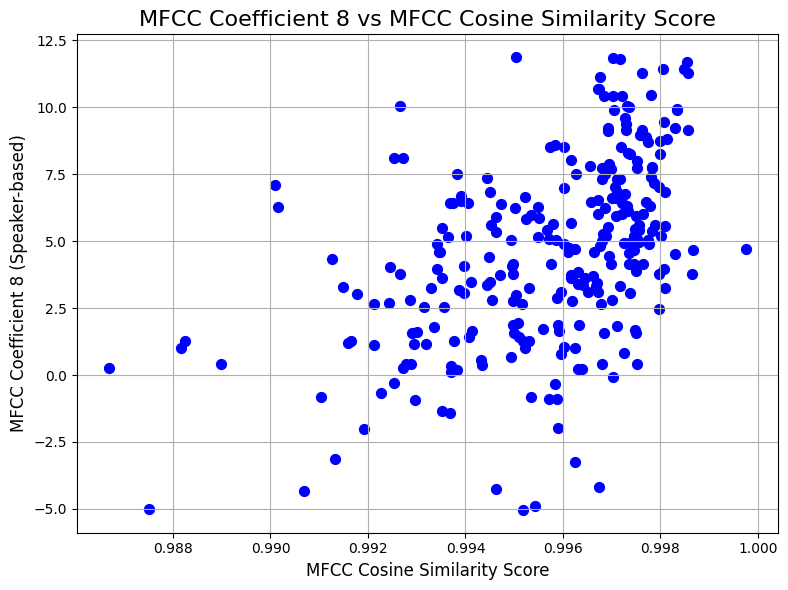

Linear correlation: 0.4775056628059492
Non-linear correlation: 0.5065546390758026


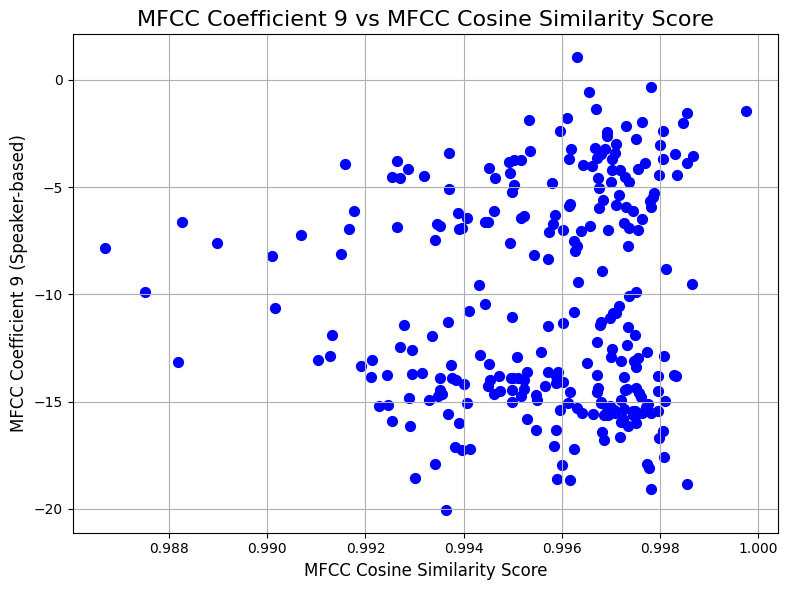

Linear correlation: 0.05813529048692256
Non-linear correlation: 0.05030509128620698


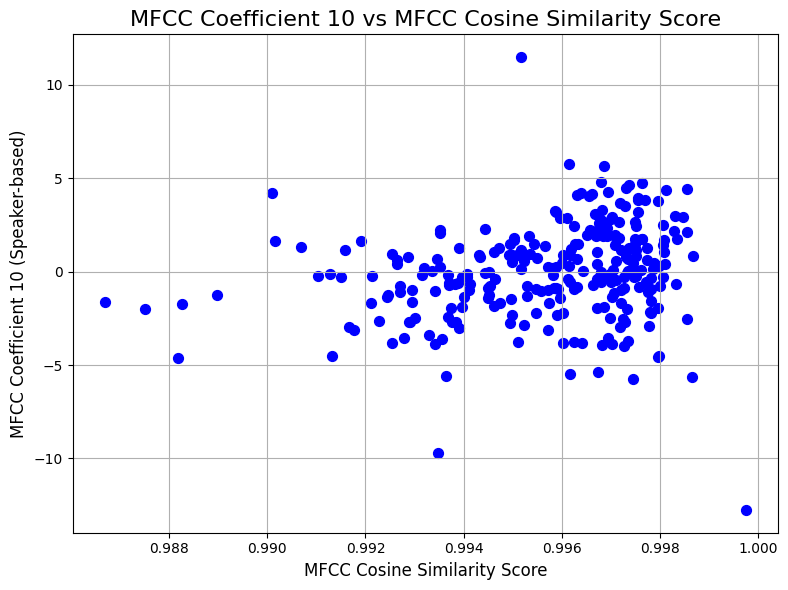

Linear correlation: 0.2005847763818653
Non-linear correlation: 0.25304789812604006


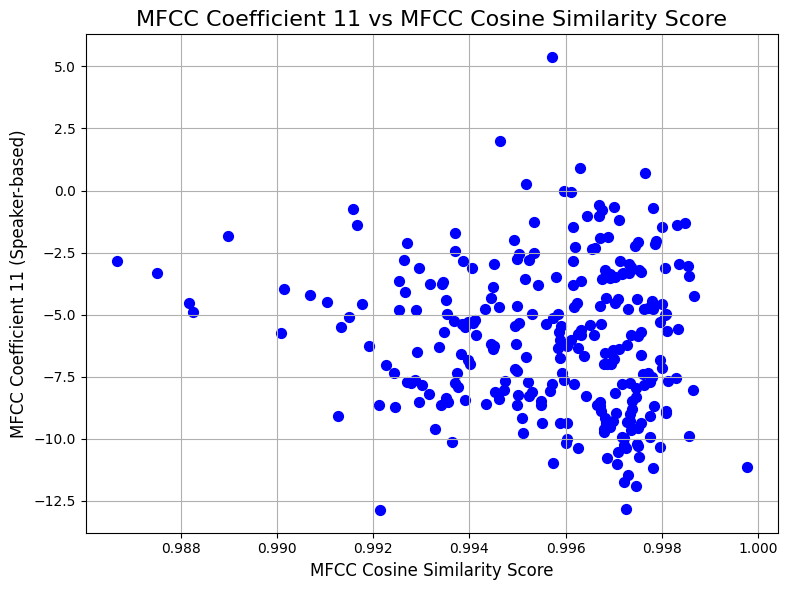

Linear correlation: -0.11663679123018475
Non-linear correlation: -0.10563514458673998


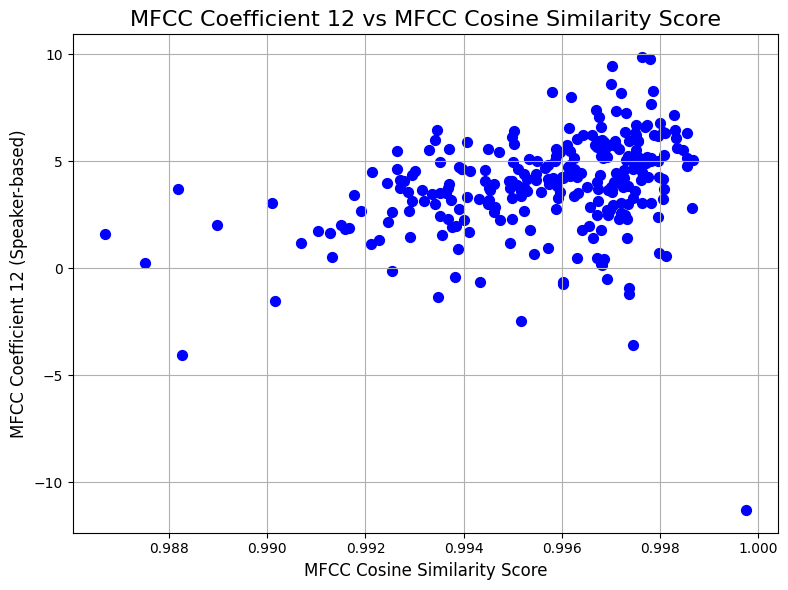

Linear correlation: 0.3130219551058759
Non-linear correlation: 0.3871626510382751


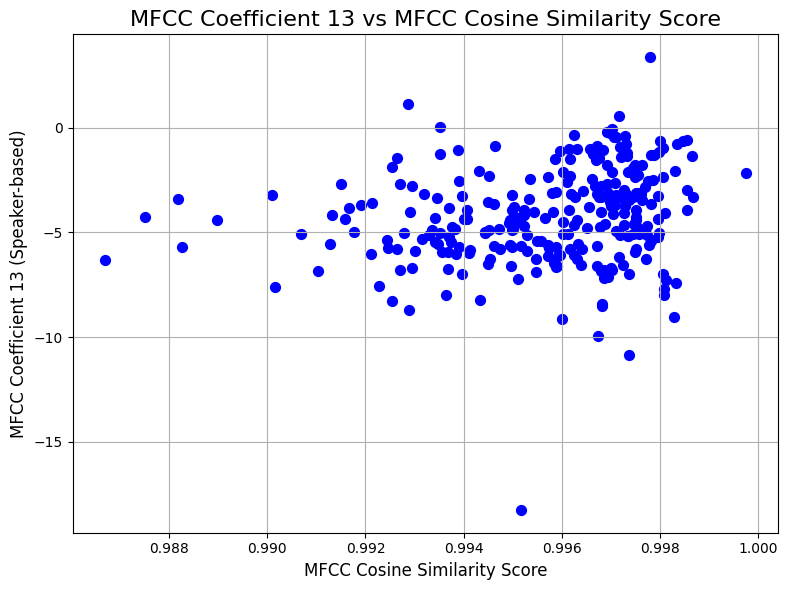

Linear correlation: 0.19418894824604255
Non-linear correlation: 0.23779453971010303


In [61]:
#analysis with mfcc 1
#speaker based
#analysis based on each mfcc coefficient,13 in total
speaker_mean_mfcc_vector = np.array(speaker_mean_mfcc_vector)
speaker_cos_sim_mfcc = np.array(speaker_cos_sim_mfcc)

for coeff_idx in range(13):
    plt.figure(figsize=(8, 6))

    plt.scatter(speaker_cos_sim_mfcc, speaker_mean_mfcc_vector[:, coeff_idx], color='b', s=50)

    plt.title(f"MFCC Coefficient {coeff_idx + 1} vs MFCC Cosine Similarity Score", fontsize=16)
    plt.xlabel("MFCC Cosine Similarity Score", fontsize=12)
    plt.ylabel(f"MFCC Coefficient {coeff_idx + 1} (Speaker-based)", fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #calculate the linear correlation level (pearson correlation)
    pearson_corr, pearson_p_value = pearsonr(speaker_mean_mfcc_vector[:, coeff_idx], speaker_cos_sim_mfcc)
    print(f'Linear correlation: {pearson_corr}')

    #calculate the none-linear correlation level (spearman’s rank correlation)
    spearman_corr, spearman_p_value = spearmanr(speaker_mean_mfcc_vector[:, coeff_idx], speaker_cos_sim_mfcc)
    print(f"Non-linear correlation: {spearman_corr}")

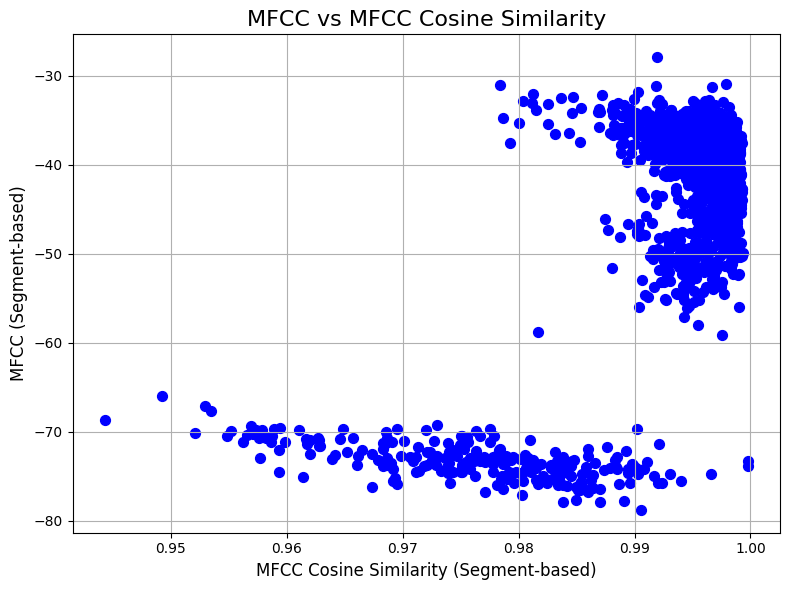

Linear correlation: 0.7260085817625244
Non-linear correlation: -0.1503223336371352


In [62]:
#correlation analysis with mfcc 2
#segment level
#use the mean value of the mean mfcc vector of each segment

seg_mean_mfcc_value = np.array(seg_mean_mfcc_value)
seg_cos_sim_mfcc = np.array(seg_cos_sim_mfcc)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim_mfcc, seg_mean_mfcc_value, color='b', s=50)

plt.title(f"MFCC vs MFCC Cosine Similarity", fontsize=16)
plt.xlabel("MFCC Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"MFCC (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(seg_mean_mfcc_value, seg_cos_sim_mfcc)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_mfcc_value, seg_cos_sim_mfcc)
print(f"Non-linear correlation: {spearman_corr}")

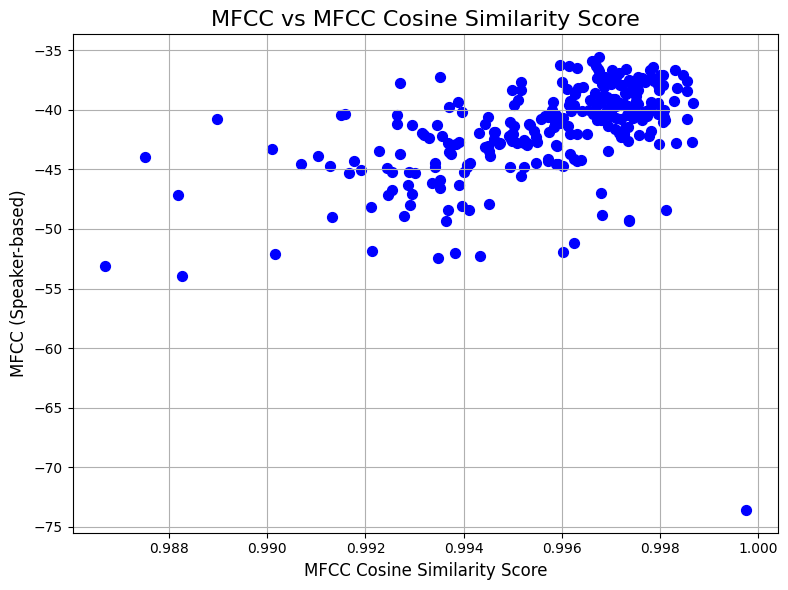

Linear correlation: 0.4580712988886343
Non-linear correlation: 0.5755504907990258


In [63]:
#correlation analysis with mfcc 2
#speaker based
#use the mean mfcc value for each speaker

speaker_mean_mfcc_value = np.array(speaker_mean_mfcc_value)
speaker_cos_sim_mfcc = np.array(speaker_cos_sim_mfcc)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim_mfcc, speaker_mean_mfcc_value, color='b', s=50)

plt.title(f"MFCC vs MFCC Cosine Similarity Score", fontsize=16)
plt.xlabel("MFCC Cosine Similarity Score", fontsize=12)
plt.ylabel(f"MFCC (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(speaker_mean_mfcc_value, speaker_cos_sim_mfcc)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_mfcc_value, speaker_cos_sim_mfcc)
print(f"Non-linear correlation: {spearman_corr}")

STEP 5.2: conduct correlation analysis between x-vectors and the mean cosine similarities of MFCCs

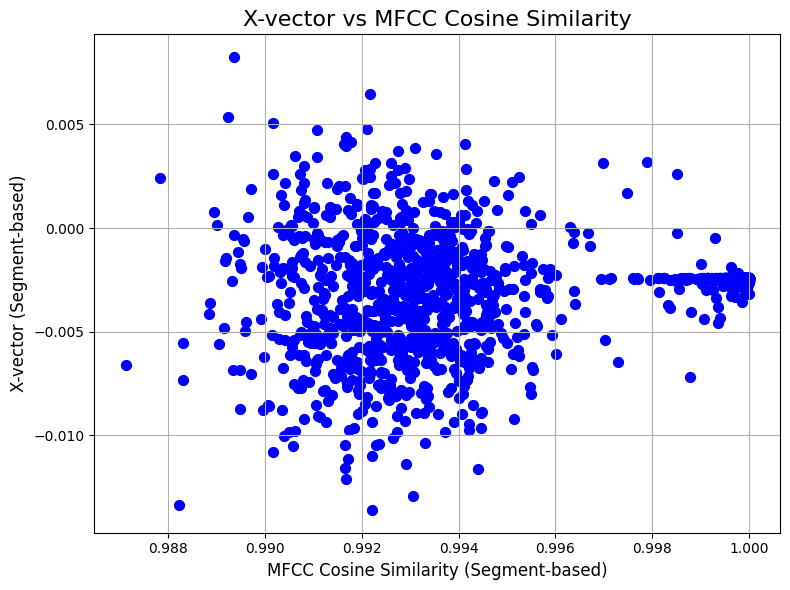

Linear correlation: 0.06929816982404034
Non-linear correlation: -0.03927073319061487


In [64]:
#analysis with xvector
#segment level
#no coefficientwise analysis due to the large number of coefficients (512)
#use the mean vector value of each segment

seg_mean_xvector_value = np.array(seg_mean_xvector_value)
seg_cos_sim_mfcc = np.array(seg_cos_sim_mfcc)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim_xvector, seg_mean_xvector_value, color='b', s=50)

plt.title(f"X-vector vs MFCC Cosine Similarity", fontsize=16)
plt.xlabel("MFCC Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"X-vector (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
seg_mean_xvector_value = np.ravel(seg_mean_xvector_value)
seg_cos_sim = np.ravel(seg_cos_sim)

pearson_corr, pearson_p_value = pearsonr(seg_mean_xvector_value, seg_cos_sim_mfcc)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_xvector_value, seg_cos_sim_mfcc)
print(f"Non-linear correlation: {spearman_corr}")

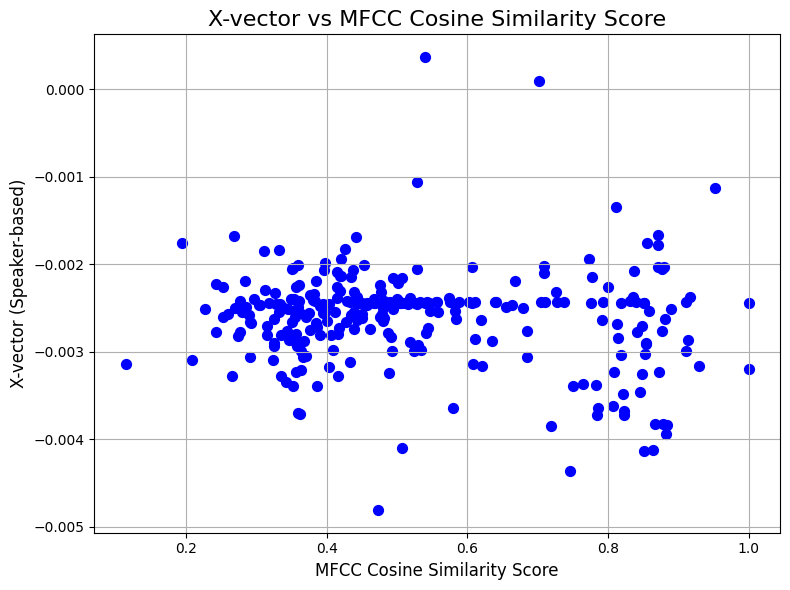

Linear correlation: 0.013514103339743502
Non-linear correlation: 0.064487012517184


In [65]:
#analysis with xvector
#speaker level
#use the mean xvector value for each speaker

speaker_mean_xvector_value = np.array(speaker_mean_xvector_value)
speaker_cos_sim_mfcc = np.array(speaker_cos_sim_mfcc)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim, speaker_mean_xvector_value, color='b', s=50)

plt.title(f"X-vector vs MFCC Cosine Similarity Score", fontsize=16)
plt.xlabel("MFCC Cosine Similarity Score", fontsize=12)
plt.ylabel(f"X-vector (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
speaker_mean_xvector_value = np.ravel(speaker_mean_xvector_value)
speaker_cos_sim = np.ravel(speaker_cos_sim)

pearson_corr, pearson_p_value = pearsonr(speaker_mean_xvector_value, speaker_cos_sim_mfcc)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_xvector_value, speaker_cos_sim_mfcc)
print(f"Non-linear correlation: {spearman_corr}")

STEP 5.3: conduct correlation analysis between embeddings and the mean cosine similarities of MFCCs

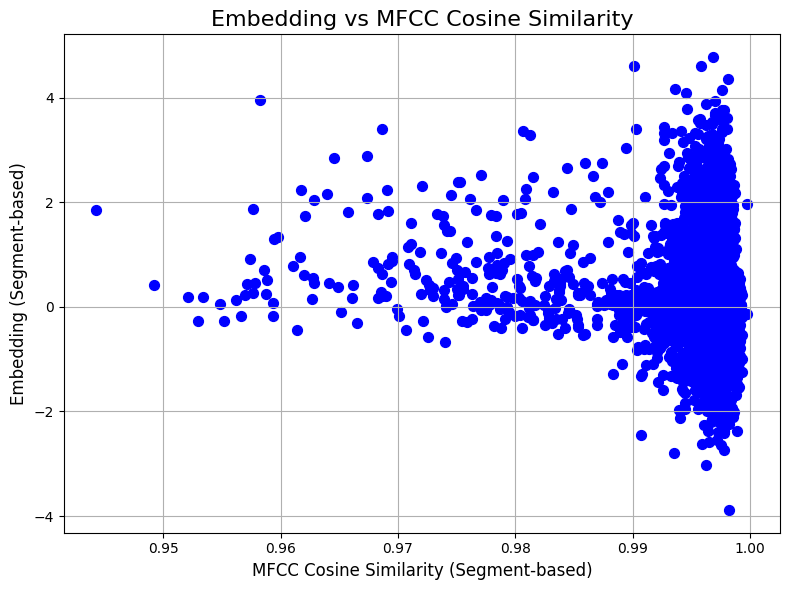

Linear correlation: -0.12933214540176477
Non-linear correlation: -0.1475489940016447


In [66]:
#segment based analysis with embedding

seg_mean_embedding_value = np.array(seg_mean_embedding_value)
seg_cos_sim_mfcc = np.array(seg_cos_sim_mfcc)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim_mfcc, seg_mean_embedding_value, color='b', s=50)

plt.title(f"Embedding vs MFCC Cosine Similarity", fontsize=16)
plt.xlabel("MFCC Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"Embedding (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(seg_mean_embedding_value, seg_cos_sim_mfcc)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_embedding_value, seg_cos_sim_mfcc)
print(f"Non-linear correlation: {spearman_corr}")

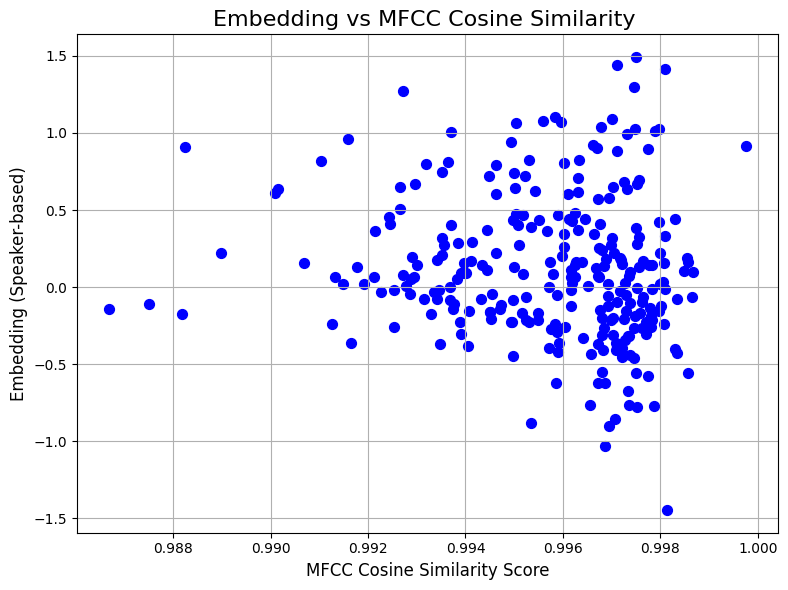

Linear correlation: -0.11209367124865746
Non-linear correlation: -0.14690266020307263


In [67]:
#speaker based analysis with embedding

speaker_mean_embedding_value = np.array(speaker_mean_embedding_value)
speaker_cos_sim_mfcc = np.array(speaker_cos_sim_mfcc)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim_mfcc, speaker_mean_embedding_value, color='b', s=50)

plt.title(f"Embedding vs MFCC Cosine Similarity ", fontsize=16)
plt.xlabel("MFCC Cosine Similarity Score", fontsize=12)
plt.ylabel(f"Embedding (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(speaker_mean_embedding_value, speaker_cos_sim_mfcc)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_embedding_value, speaker_cos_sim_mfcc)
print(f"Non-linear correlation: {spearman_corr}")

STEP 6: conduct correlation analysis 3, which is the analysis between speech features and the mean cosine similarities of x-vectors

STEP 6.1: conduct correlation analysis between MFCCs and the mean cosine similarities of x-vectors

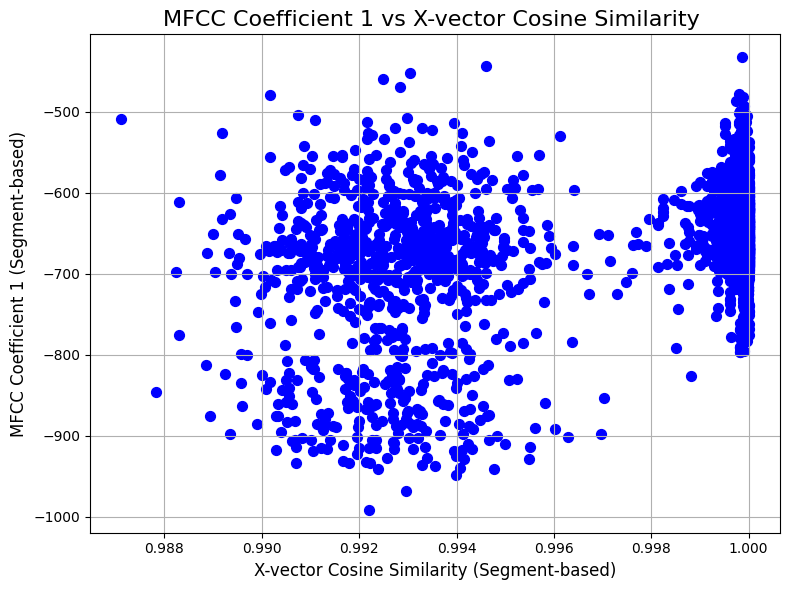

Linear correlation: 0.40457396465166406
Non-linear correlation: 0.14958616625013793


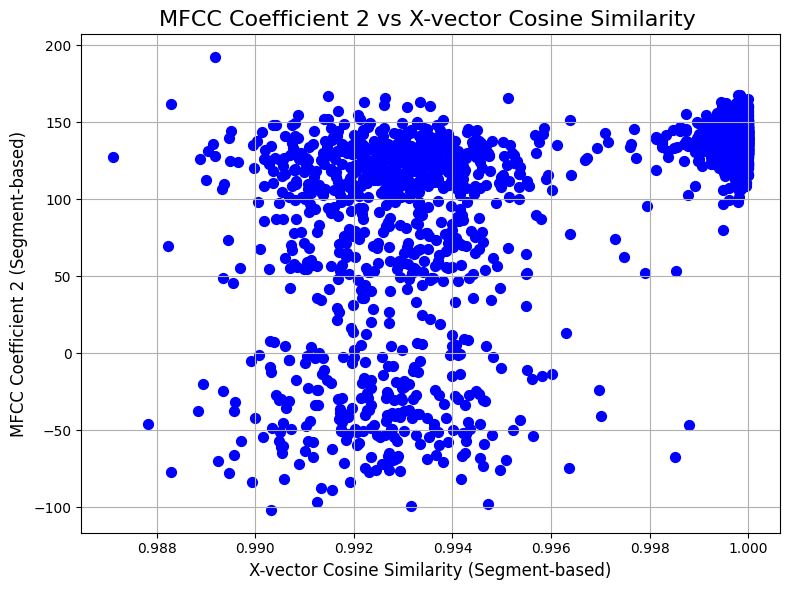

Linear correlation: 0.6388368299496804
Non-linear correlation: 0.4318579873121064


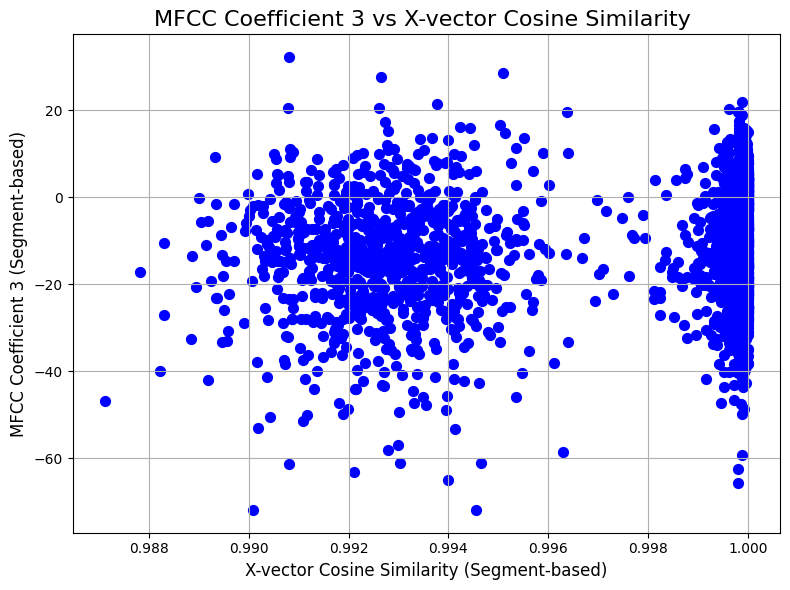

Linear correlation: 0.10677534912300296
Non-linear correlation: 0.1665170342338324


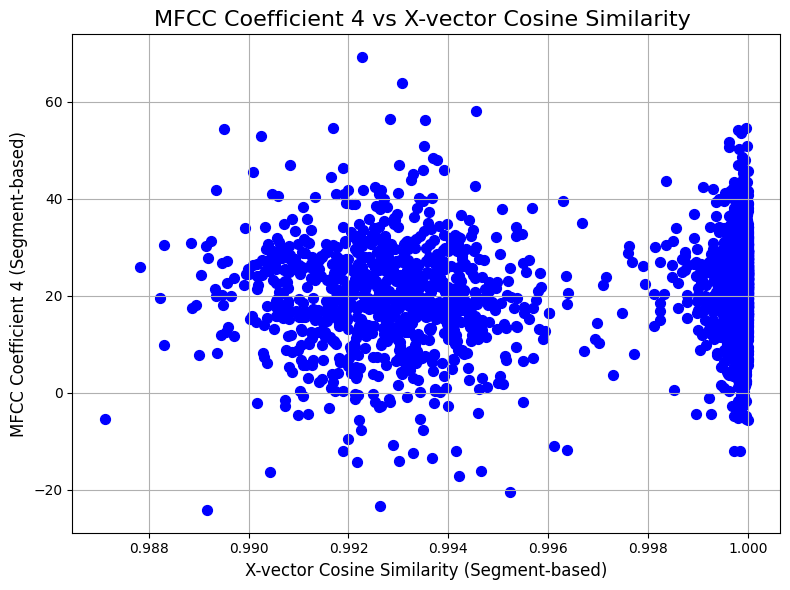

Linear correlation: 0.1589454765465766
Non-linear correlation: 0.15998620493658494


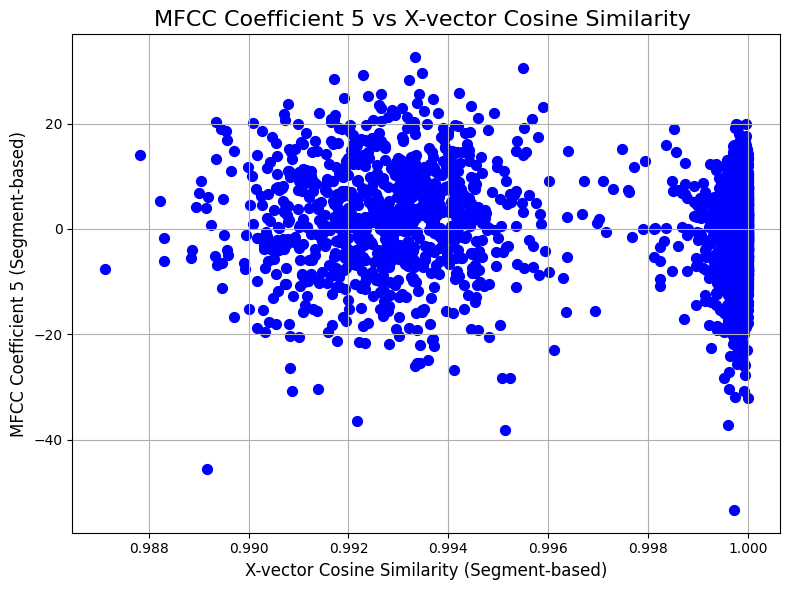

Linear correlation: -0.13772262826763346
Non-linear correlation: -0.06057371050096529


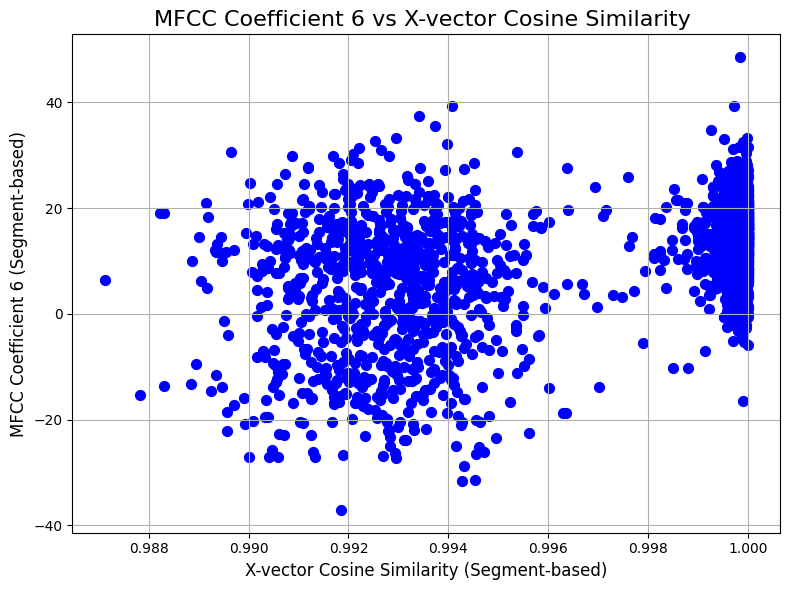

Linear correlation: 0.45967720482942986
Non-linear correlation: 0.2582570575704439


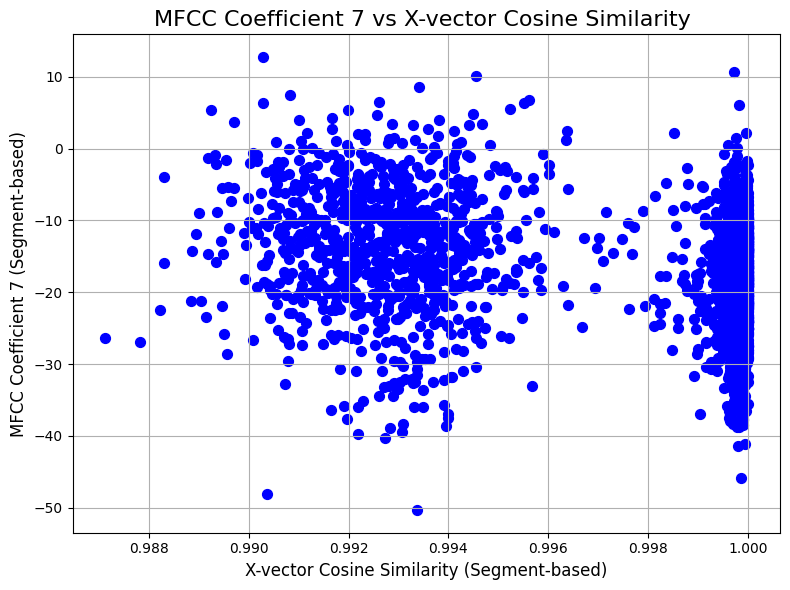

Linear correlation: -0.2523876604294399
Non-linear correlation: -0.09883430240821148


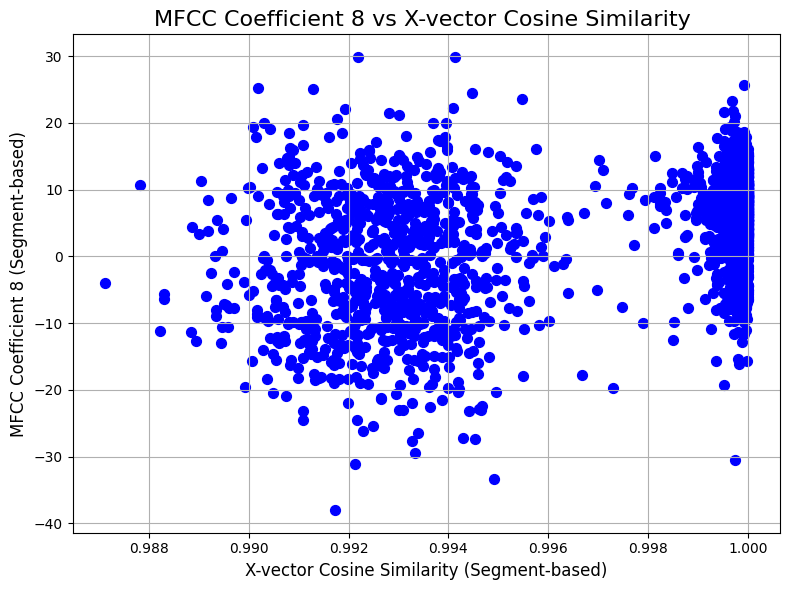

Linear correlation: 0.3987785227861077
Non-linear correlation: 0.15990323185304633


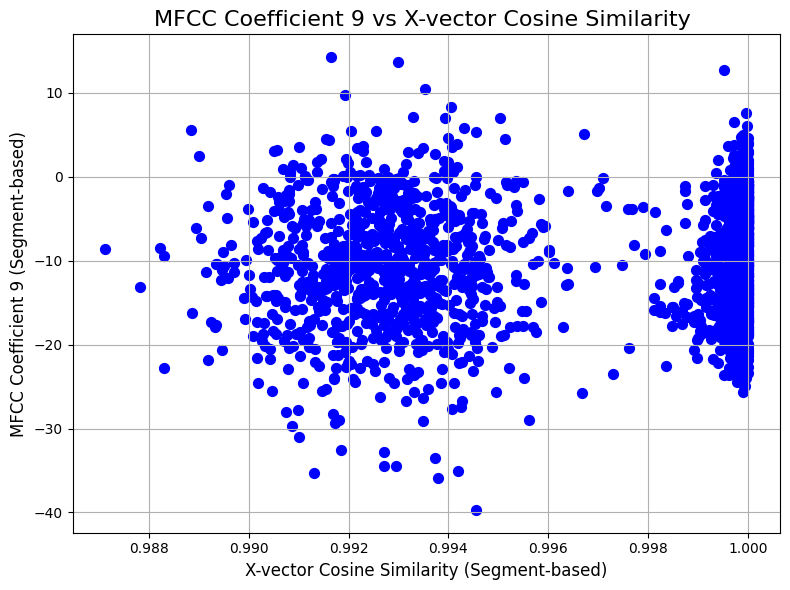

Linear correlation: 0.0626805917474057
Non-linear correlation: 0.15867192611361236


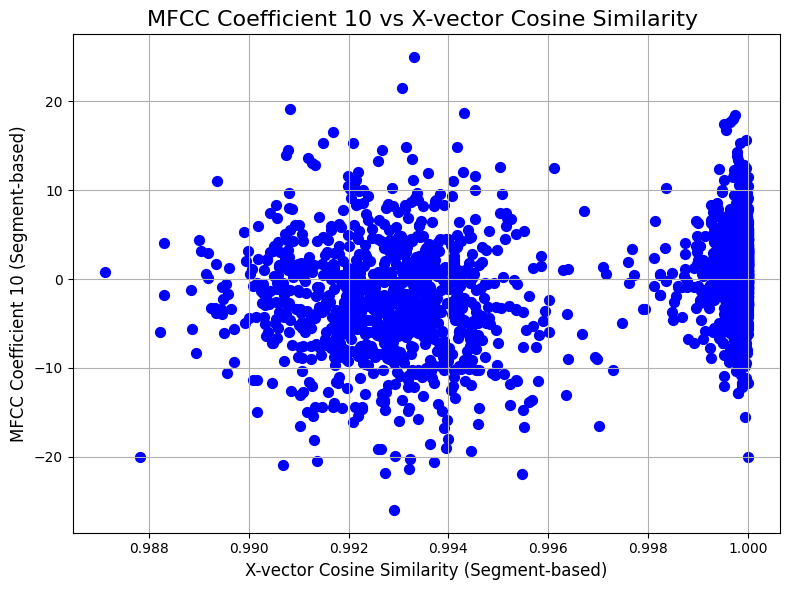

Linear correlation: 0.26736300637070093
Non-linear correlation: 0.21846351866451594


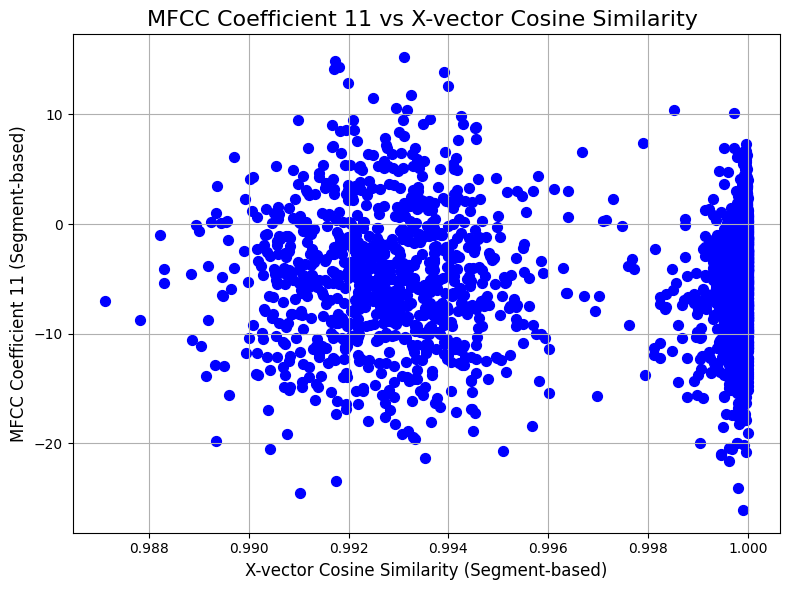

Linear correlation: -0.07943473347591616
Non-linear correlation: 0.07329219417551511


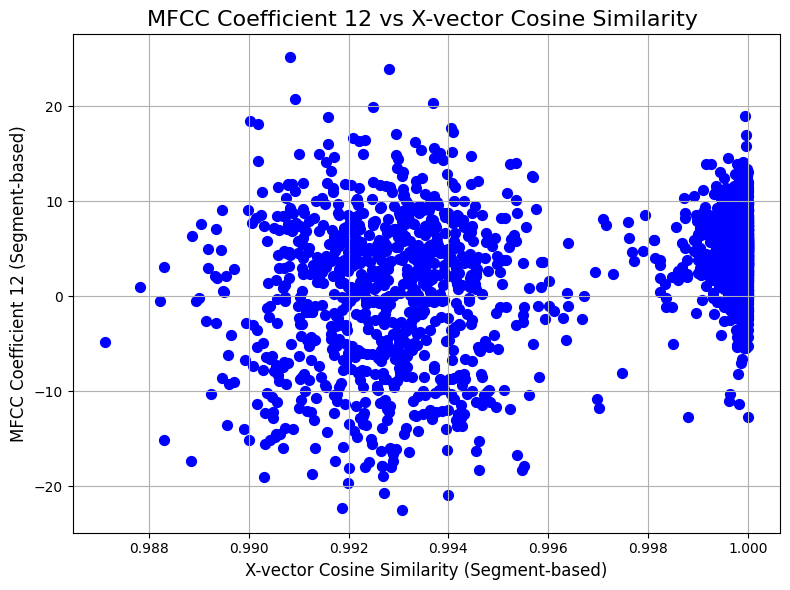

Linear correlation: 0.4010371637733709
Non-linear correlation: 0.22931243805677715


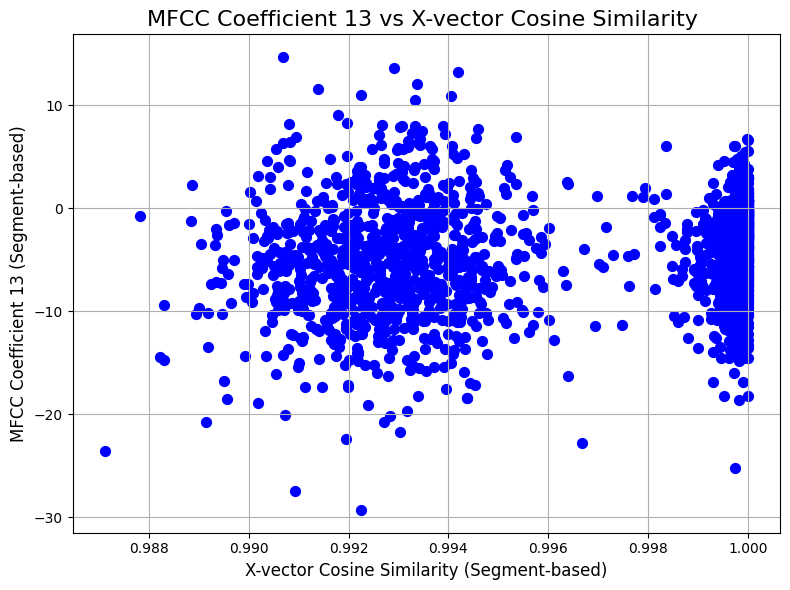

Linear correlation: 0.12952657324090916
Non-linear correlation: 0.15294853080655457


In [69]:
#correlation analysis with mfcc 1
#segment level
#analysis based on each mfcc coefficient,13 in total
seg_mean_mfcc_vector = np.array(seg_mean_mfcc_vector)
seg_cos_sim_xvector = np.array(seg_cos_sim_xvector)

for coeff_idx in range(13):
    plt.figure(figsize=(8, 6))

    plt.scatter(seg_cos_sim_xvector, seg_mean_mfcc_vector[:, coeff_idx], color='b', s=50)

    plt.title(f"MFCC Coefficient {coeff_idx + 1} vs X-vector Cosine Similarity ", fontsize=16)
    plt.xlabel("X-vector Cosine Similarity (Segment-based)", fontsize=12)
    plt.ylabel(f"MFCC Coefficient {coeff_idx + 1} (Segment-based)", fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #calculate the linear correlation level (pearson correlation)
    pearson_corr, pearson_p_value = pearsonr(seg_mean_mfcc_vector[:, coeff_idx], seg_cos_sim_xvector)
    print(f'Linear correlation: {pearson_corr}')

    #calculate the none-linear correlation level (spearman’s rank correlation)
    spearman_corr, spearman_p_value = spearmanr(seg_mean_mfcc_vector[:, coeff_idx], seg_cos_sim_xvector)
    print(f"Non-linear correlation: {spearman_corr}")

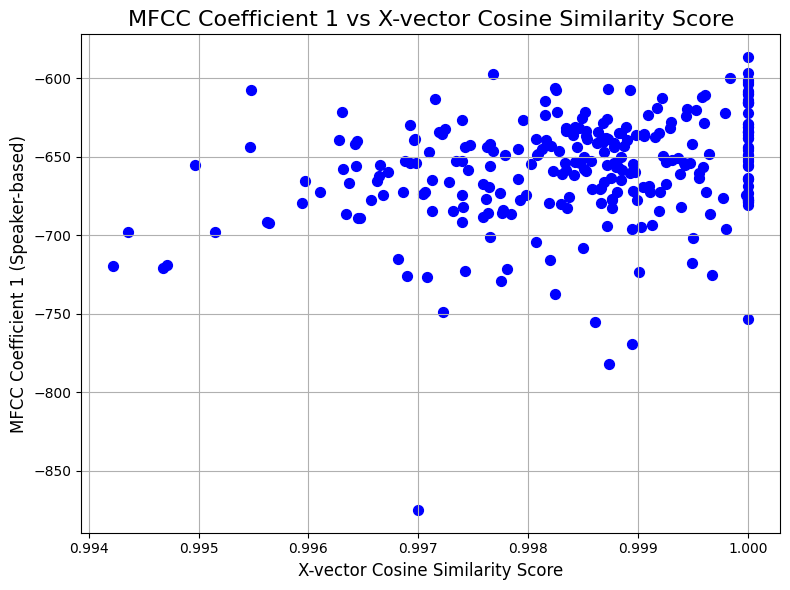

Linear correlation: 0.28214361481874967
Non-linear correlation: 0.2761346606759644


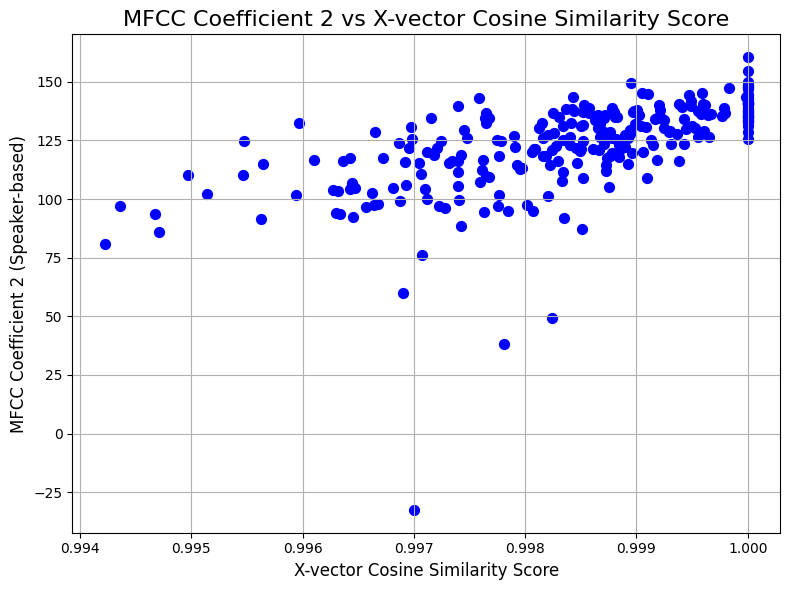

Linear correlation: 0.6108958739015339
Non-linear correlation: 0.723629263886301


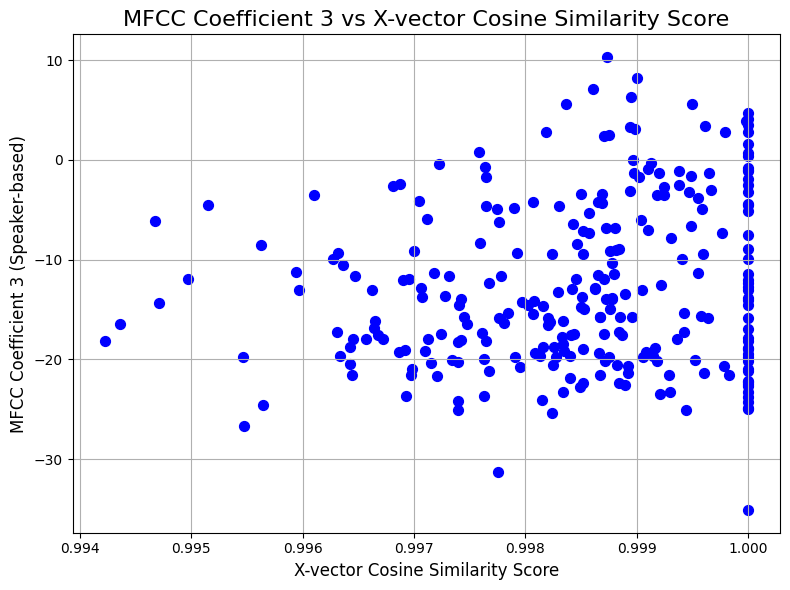

Linear correlation: 0.1645188698675064
Non-linear correlation: 0.15261080466745341


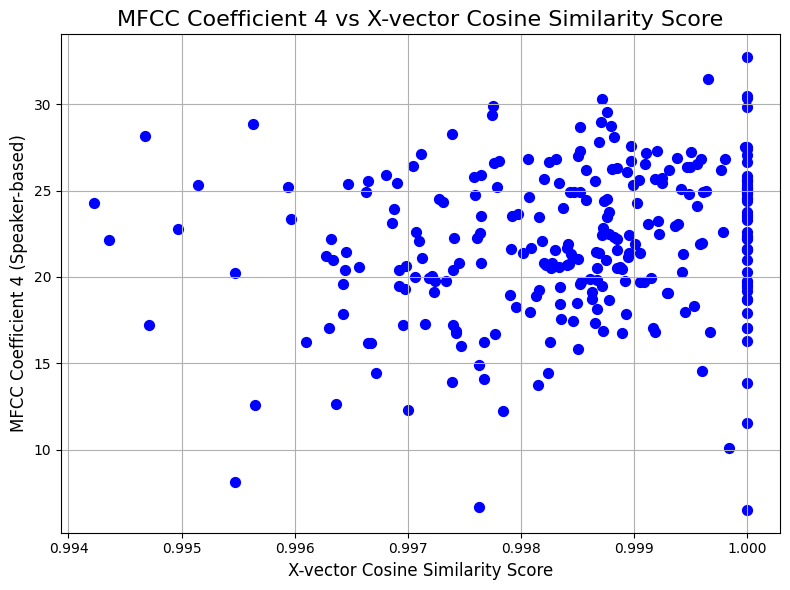

Linear correlation: 0.17637415961952063
Non-linear correlation: 0.19584992949948407


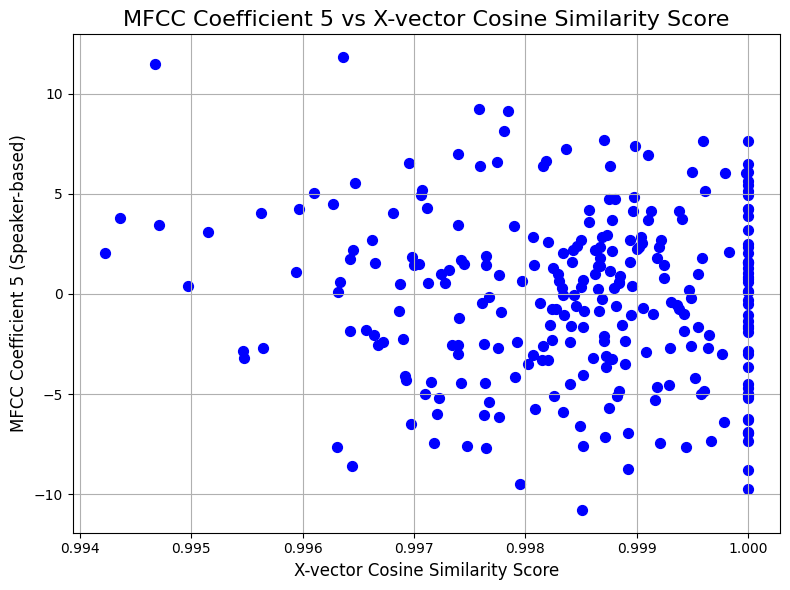

Linear correlation: -0.09802217635704853
Non-linear correlation: -0.04976618918547643


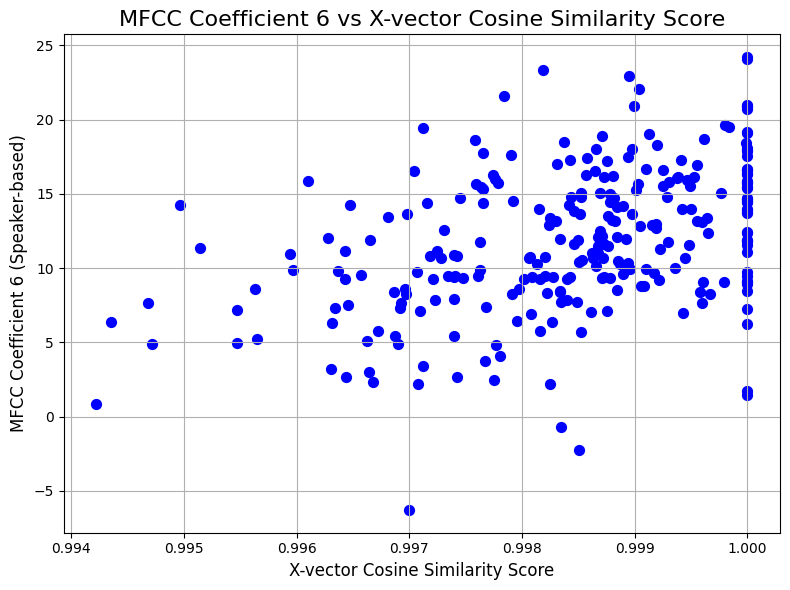

Linear correlation: 0.4279038309285215
Non-linear correlation: 0.4295452516329959


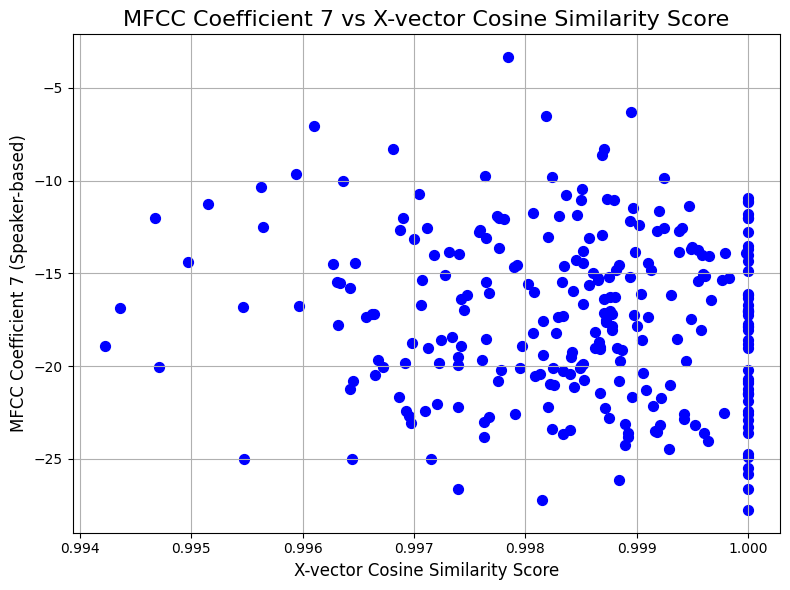

Linear correlation: -0.10789914335875443
Non-linear correlation: -0.08495256382734359


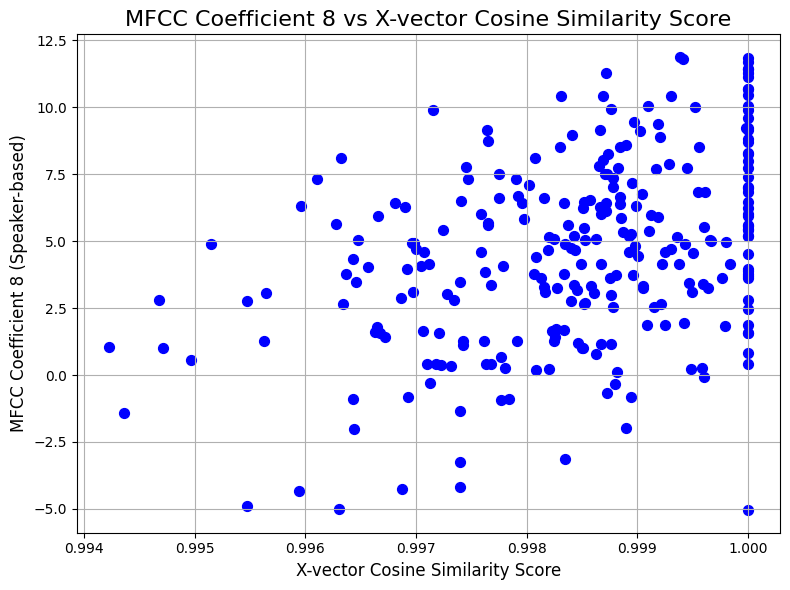

Linear correlation: 0.3938522167615199
Non-linear correlation: 0.37771083681632545


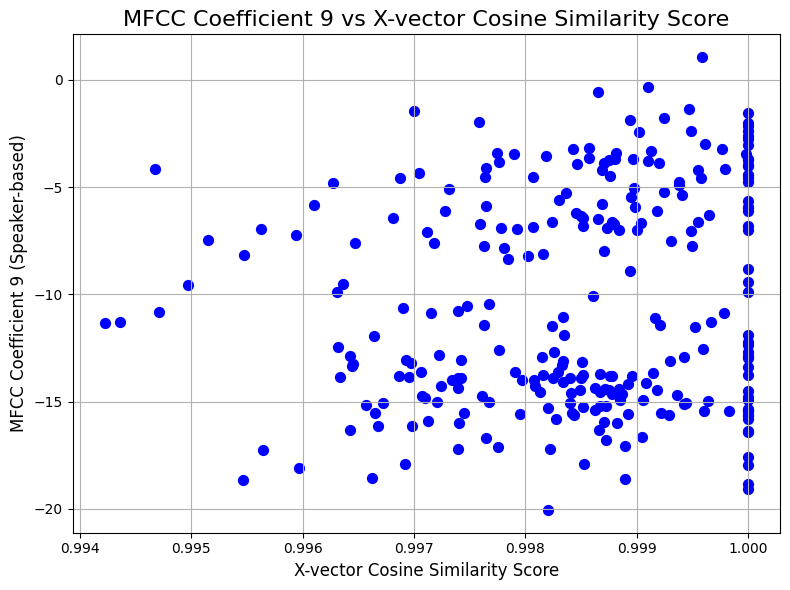

Linear correlation: 0.14204792469111133
Non-linear correlation: 0.15036615559002897


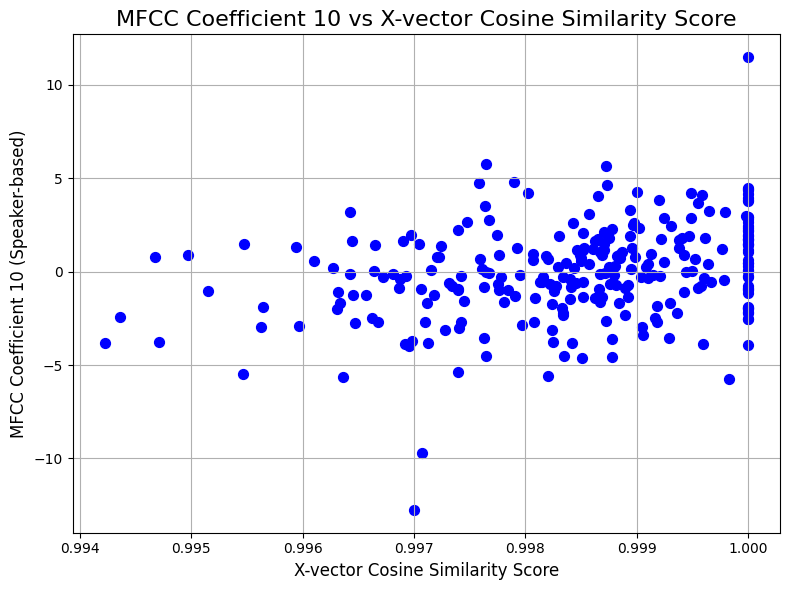

Linear correlation: 0.30926109437360955
Non-linear correlation: 0.3019696879319957


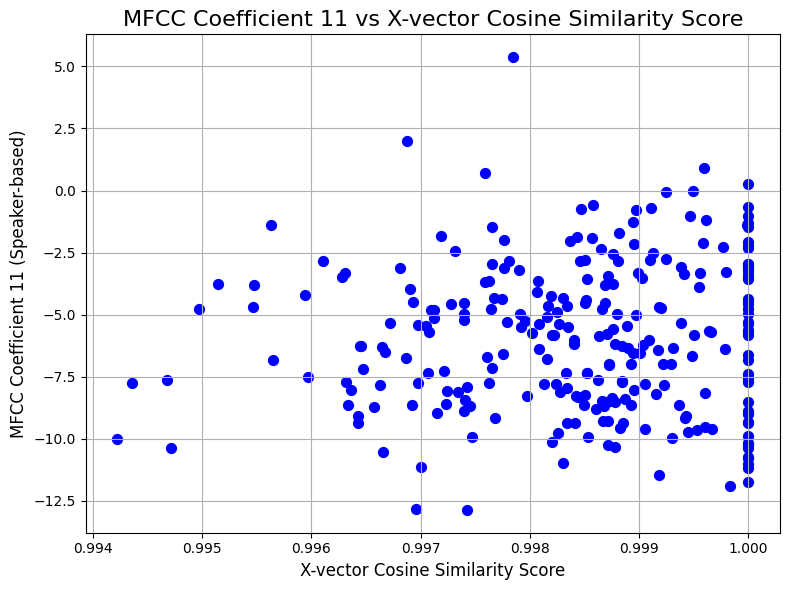

Linear correlation: 0.04717993880068154
Non-linear correlation: 0.03475421259323769


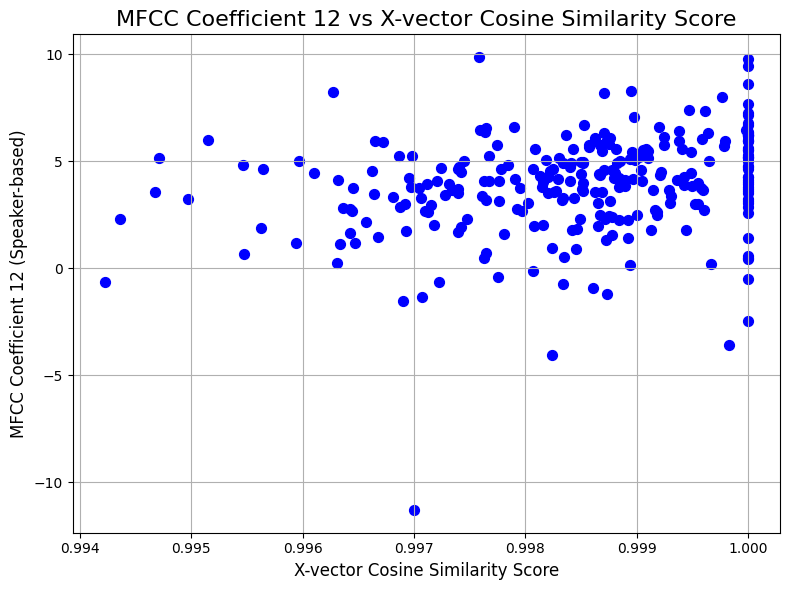

Linear correlation: 0.24029850979401005
Non-linear correlation: 0.2824895236827476


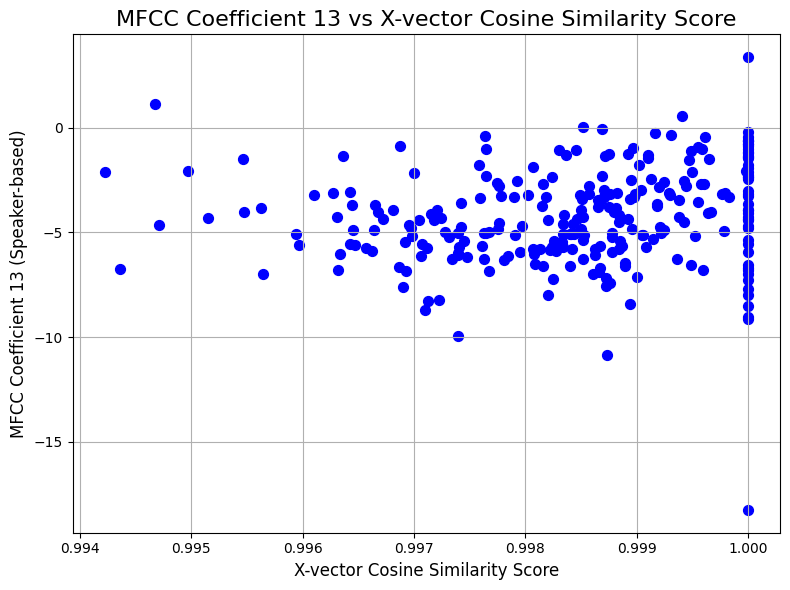

Linear correlation: 0.1406204265261923
Non-linear correlation: 0.24437150404804925


In [70]:
#analysis with mfcc 1
#speaker based
#analysis based on each mfcc coefficient,13 in total
speaker_mean_mfcc_vector = np.array(speaker_mean_mfcc_vector)
speaker_cos_sim_xvector = np.array(speaker_cos_sim_xvector)

for coeff_idx in range(13):
    plt.figure(figsize=(8, 6))

    plt.scatter(speaker_cos_sim_xvector, speaker_mean_mfcc_vector[:, coeff_idx], color='b', s=50)

    plt.title(f"MFCC Coefficient {coeff_idx + 1} vs X-vector Cosine Similarity Score", fontsize=16)
    plt.xlabel("X-vector Cosine Similarity Score", fontsize=12)
    plt.ylabel(f"MFCC Coefficient {coeff_idx + 1} (Speaker-based)", fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #calculate the linear correlation level (pearson correlation)
    pearson_corr, pearson_p_value = pearsonr(speaker_mean_mfcc_vector[:, coeff_idx], speaker_cos_sim_xvector)
    print(f'Linear correlation: {pearson_corr}')

    #calculate the none-linear correlation level (spearman’s rank correlation)
    spearman_corr, spearman_p_value = spearmanr(speaker_mean_mfcc_vector[:, coeff_idx], speaker_cos_sim_xvector)
    print(f"Non-linear correlation: {spearman_corr}")

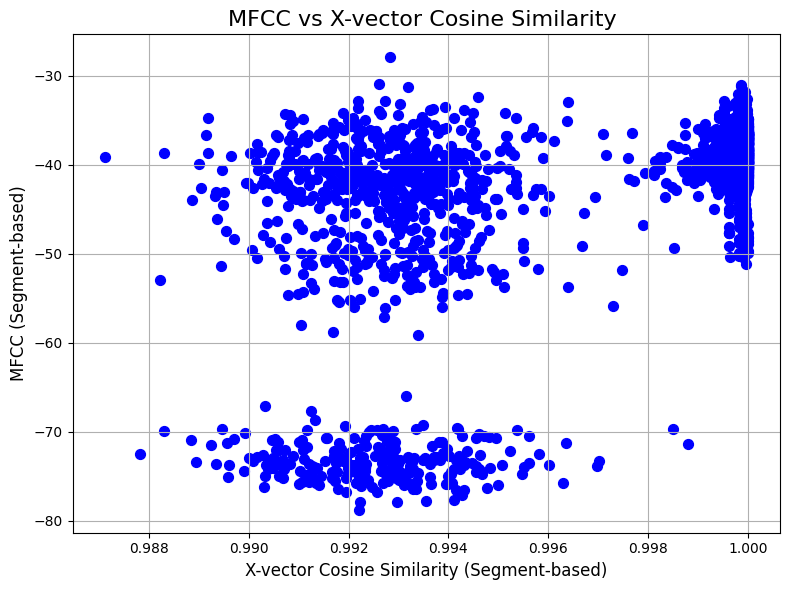

Linear correlation: 0.5827721066727627
Non-linear correlation: 0.3918382363109417


In [71]:
#analysis with mfcc 2
#segment based
#use the mean value of the mean mfcc vector of each segment

seg_mean_mfcc_value = np.array(seg_mean_mfcc_value)
seg_cos_sim_xvector = np.array(seg_cos_sim_xvector)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim_xvector, seg_mean_mfcc_value, color='b', s=50)

plt.title(f"MFCC vs X-vector Cosine Similarity ", fontsize=16)
plt.xlabel("X-vector Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"MFCC (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(seg_mean_mfcc_value, seg_cos_sim_xvector)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_mfcc_value, seg_cos_sim_xvector)
print(f"Non-linear correlation: {spearman_corr}")

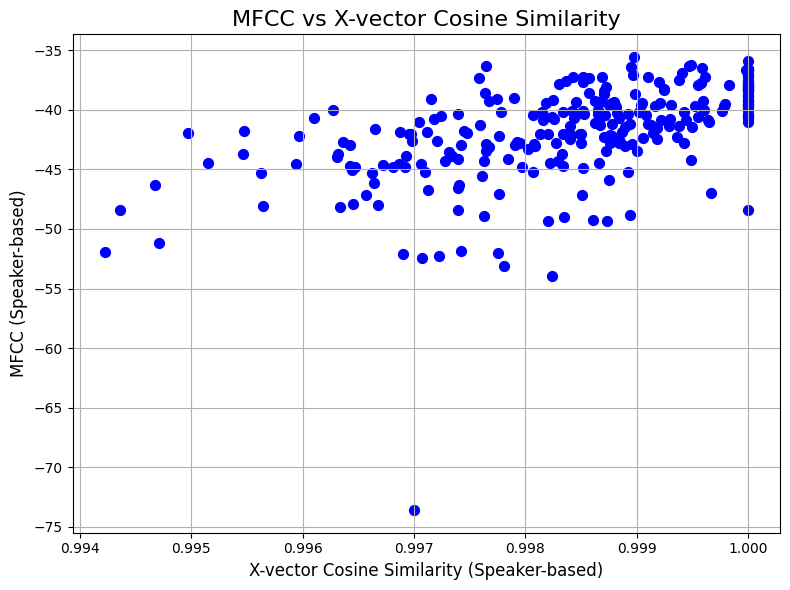

Linear correlation: 0.5440529624069129
Non-linear correlation: 0.6315585417660045


In [72]:
#analysis with mfcc 2
#speaker based
#use the mean mfcc value for each speaker

speaker_mean_mfcc_value = np.array(speaker_mean_mfcc_value)
speaker_cos_sim_xvector = np.array(speaker_cos_sim_xvector)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim_xvector, speaker_mean_mfcc_value, color='b', s=50)

plt.title(f"MFCC vs X-vector Cosine Similarity", fontsize=16)
plt.xlabel("X-vector Cosine Similarity (Speaker-based)", fontsize=12)
plt.ylabel(f"MFCC (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(speaker_mean_mfcc_value, speaker_cos_sim_xvector)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_mfcc_value, speaker_cos_sim_xvector)
print(f"Non-linear correlation: {spearman_corr}")

STEP 6.2: conduct correlation analysis between xvectors and the mean cosine similarities of x-vectors

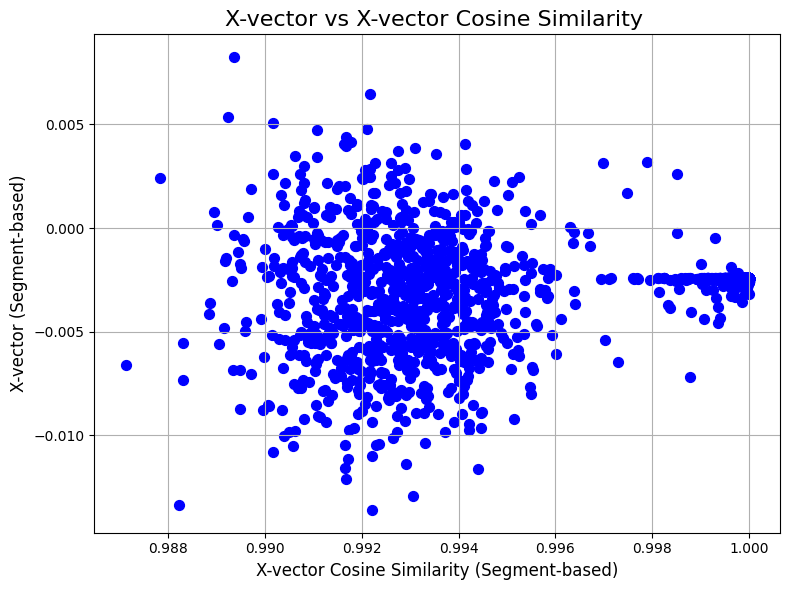

Linear correlation: 0.23148796682914982
Non-linear correlation: 0.19848039422530026


In [73]:
#segment based analysis with xvector
#no coefficientwise analysis due to the large number of coefficients (512)
#use the mean vector value of each segment

seg_mean_xvector_value = np.array(seg_mean_xvector_value)
seg_cos_sim_xvector = np.array(seg_cos_sim_xvector)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim_xvector, seg_mean_xvector_value, color='b', s=50)

plt.title(f"X-vector vs X-vector Cosine Similarity ", fontsize=16)
plt.xlabel("X-vector Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"X-vector (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
seg_mean_xvector_value = np.ravel(seg_mean_xvector_value)
seg_cos_sim = np.ravel(seg_cos_sim)

pearson_corr, pearson_p_value = pearsonr(seg_mean_xvector_value, seg_cos_sim_xvector)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_xvector_value, seg_cos_sim_xvector)
print(f"Non-linear correlation: {spearman_corr}")



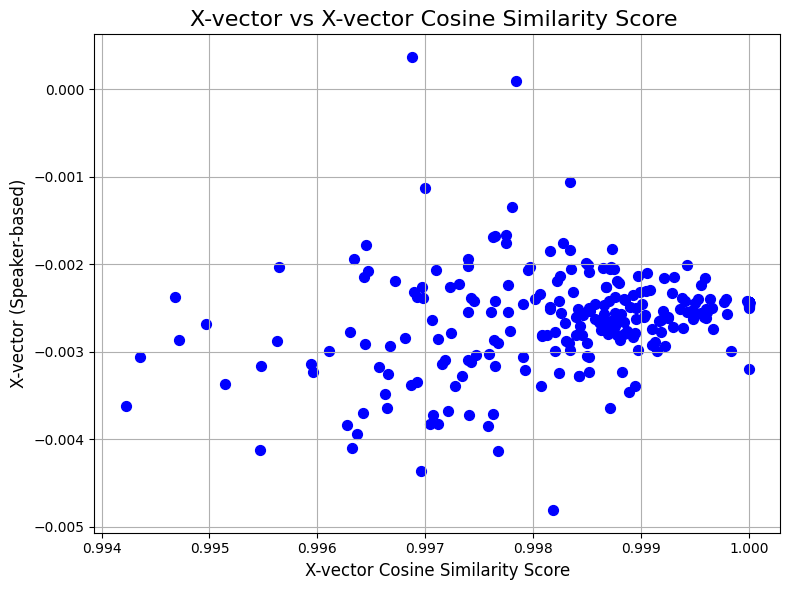

Linear correlation: 0.25622824240074965
Non-linear correlation: 0.26461526516200756


In [74]:
#speaker based analysis with xvector
#use the mean xvector value for each speaker

speaker_mean_xvector_value = np.array(speaker_mean_xvector_value)
speaker_cos_sim_xvector = np.array(speaker_cos_sim_xvector)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim_xvector, speaker_mean_xvector_value, color='b', s=50)

plt.title(f"X-vector vs X-vector Cosine Similarity Score ", fontsize=16)
plt.xlabel("X-vector Cosine Similarity Score", fontsize=12)
plt.ylabel(f"X-vector (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
speaker_mean_xvector_value = np.ravel(speaker_mean_xvector_value)
speaker_cos_sim = np.ravel(speaker_cos_sim)

pearson_corr, pearson_p_value = pearsonr(speaker_mean_xvector_value, speaker_cos_sim_xvector)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_xvector_value, speaker_cos_sim_xvector)
print(f"Non-linear correlation: {spearman_corr}")

STEP 6.3: conduct correlation analysis between embeddings and the mean cosine similarities of x-vectors

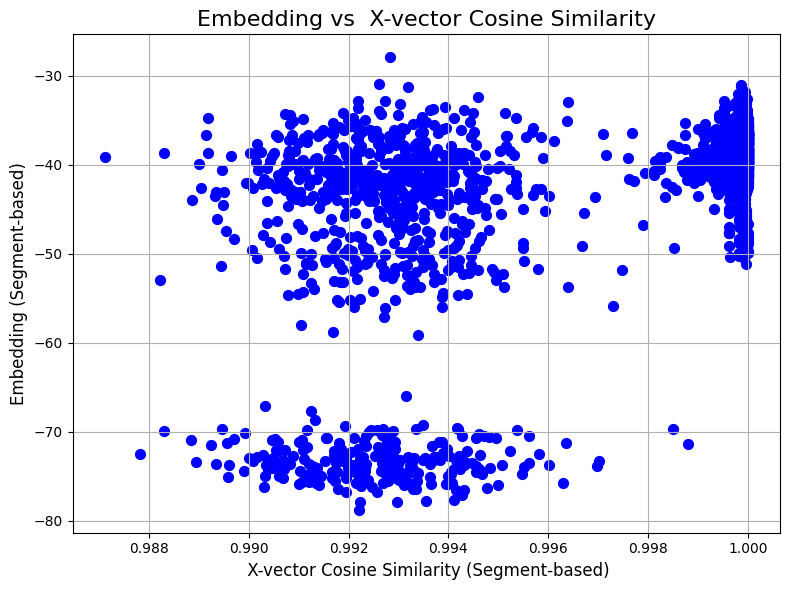

Linear correlation: -0.060185795853553145
Non-linear correlation: -0.010055039179267729


In [75]:
#segment based analysis with embedding

seg_mean_embedding_value = np.array(seg_mean_embedding_value)
seg_cos_sim_xvector = np.array(seg_cos_sim_xvector)

plt.figure(figsize=(8, 6))
plt.scatter(seg_cos_sim_xvector, seg_mean_mfcc_value, color='b', s=50)

plt.title(f"Embedding vs  X-vector Cosine Similarity", fontsize=16)
plt.xlabel(" X-vector Cosine Similarity (Segment-based)", fontsize=12)
plt.ylabel(f"Embedding (Segment-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(seg_mean_embedding_value, seg_cos_sim_xvector)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(seg_mean_embedding_value, seg_cos_sim_xvector)
print(f"Non-linear correlation: {spearman_corr}")

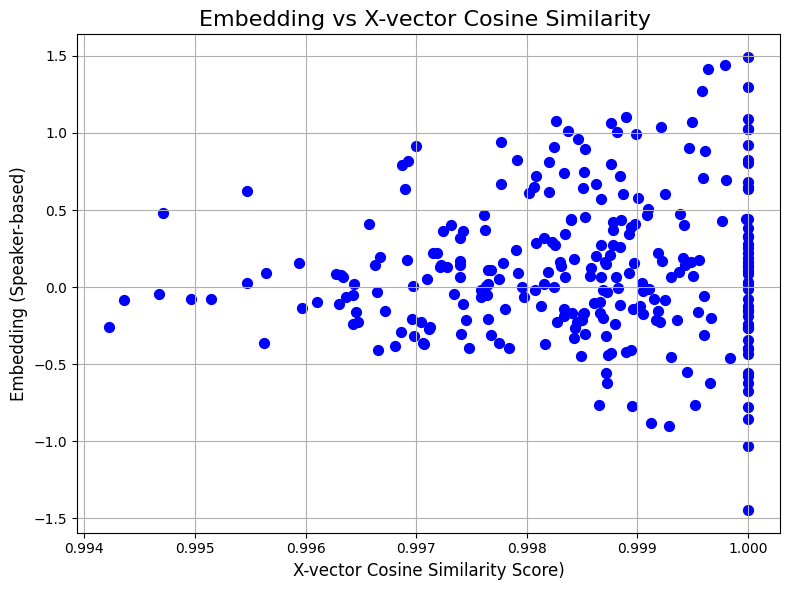

Linear correlation: 0.06756289153020277
Non-linear correlation: 0.040607852065602065


In [76]:
#speaker based analysis with embedding

speaker_mean_embedding_value = np.array(speaker_mean_embedding_value)
speaker_cos_sim_xvector = np.array(speaker_cos_sim_xvector)

plt.figure(figsize=(8, 6))
plt.scatter(speaker_cos_sim_xvector, speaker_mean_embedding_value, color='b', s=50)

plt.title(f"Embedding vs X-vector Cosine Similarity ", fontsize=16)
plt.xlabel("X-vector Cosine Similarity Score)", fontsize=12)
plt.ylabel(f"Embedding (Speaker-based)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(speaker_mean_embedding_value, speaker_cos_sim_xvector)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(speaker_mean_embedding_value, speaker_cos_sim_xvector)
print(f"Non-linear correlation: {spearman_corr}")

In [78]:
#save the new dataframe again
path_2 = '/content/drive/MyDrive/Speaker_diarization_project_data/data_processed_cos_sim.pkl'

add_mean_xvector_df.to_pickle(path_2)

print(f"DataFrame saved to {path_2}")

DataFrame saved to /content/drive/MyDrive/Speaker_diarization_project_data/data_processed_cos_sim.pkl
